<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">Data Science Project</h3>

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">Aim</h3>

**_The aim_** of this notebook is to provide an analytical perspective on the e-commerce landscape in Brazil. To achieve this, an exploratory data analysis is first conducted, utilizing graphical tools to generate informative and self-explanatory visualizations for a deeper understanding of online shopping behavior in Brazil.

Throughout this notebook, a comprehensive exploration of the data is carried out, creating meaningful charts to elucidate concepts and derive insights. Towards the end, a detailed process of text preparation and sentiment classification based on customer reviews from online platforms is presented. It is hoped that this notebook proves engaging.

# 1. Installing and Loading Libraries

In [34]:
pip install folium --upgrade

Note: you may need to restart the kernel to use updated packages.


In [35]:
!pip install wordcloud

In [36]:
!pip install lightgbm

In [37]:
# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
from wordcloud import WordCloud
from collections import Counter
from PIL import Image


# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

# 2. Data Preprocessing

<a id="2.1"></a>
<font color="dimgrey" size=+2.0><b>2.1 Reading Data</b></font>

In this task, several data sources exist, each pertaining to a particular aspect of e-commerce sales. The files consist of:

    olist_customers_dataset.csv
    olist_geolocation_dataset.csv
    olist_orders_dataset.csv
    olist_order_items_dataset.csv
    olist_order_payments_dataset.csv
    olist_order_reviews_dataset.csv
    olist_products_dataset.csv
    olist_sellers_dataset.csv
    product_category_name_translation.csv
    
The interconnections between these files are explained in the accompanying documentation. By reading and conducting an initial analysis of all the datasets, a foundation is established for making well-informed decisions during subsequent exploratory data analysis.

In [38]:
# Reading all the files
path = 'D:/DS PROJECT/Datasets/'

olist_customer = pd.read_csv(path + 'olist_customers_dataset.csv')
olist_geolocation = pd.read_csv(path + 'olist_geolocation_dataset.csv')
olist_orders = pd.read_csv(path + 'olist_orders_dataset.csv')
olist_order_items = pd.read_csv(path + 'olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv(path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(path + 'olist_order_reviews_dataset.csv')
olist_products = pd.read_csv(path + 'olist_products_dataset.csv')
olist_sellers = pd.read_csv(path + 'olist_sellers_dataset.csv')

Prior to compiling a comprehensive dataset containing all relevant information, an looking of the dimensions of each individual dataset is useful for initial understanding. It will facilitate more precise decisions regarding the appropriate usage of joining statements.

In [39]:
# Collections for each dataset
datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments,
            olist_order_reviews, olist_products, olist_sellers]
names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments',
         'olist_order_reviews', 'olist_products', 'olist_sellers']

# Creating a DataFrame with useful information about all datasets

data_info = pd.DataFrame(columns=['dataset', 'n_rows', 'n_cols', 'null_amount', 'qty_null_columns', 'null_columns'])

for name, dataset in zip(names, datasets):
    data_info = data_info.append({
        'dataset': name,
        'n_rows': dataset.shape[0],
        'n_cols': dataset.shape[1],
        'null_amount': dataset.isnull().sum().sum(),
        'qty_null_columns': len([col for col, null in dataset.isnull().sum().items() if null > 0]),
        'null_columns': ', '.join([col for col, null in dataset.isnull().sum().items() if null > 0])
    }, ignore_index=True)

data_info.style.background_gradient(subset=['n_rows', 'n_cols', 'null_amount', 'qty_null_columns'])

C:\Users\Achala\AppData\Local\Temp\ipykernel_13132\2066213747.py:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Achala\AppData\Local\Temp\ipykernel_13132\2066213747.py:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Achala\AppData\Local\Temp\ipykernel_13132\2066213747.py:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Achala\AppData\Local\Temp\ipykernel_13132\2066213747.py:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Achala\AppData\Local\Temp\ipykernel_13132\2066213747.py:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

Above code generates a summary table containing information about each dataset in the datasets list. The output DataFrame, data_info, includes the following information for each dataset,

    dataset: The name of the dataset
    n_rows: The number of rows in the dataset
    n_cols: The number of columns in the dataset
    null_amount: The total number of null values in the dataset
    qty_null_columns: The number of columns containing at least one null value
    null_columns: The names of the columns containing null values, separated by commas
    
The zip function is used to iterate through the names and datasets lists simultaneously. For each dataset, the relevant information is calculated and appended as a new row to the data_info DataFrame

"style.background_gradient()" method is applied to the DataFrame, which creates a color gradient based on the values in the DataFrame, making it easier to visualize the distribution of values across the datasets.

<a id="2.2"></a>
<font color="dimgrey" size=+2.0><b>2.2 Understanding Data</b></font>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Attributes Description</a>

Let's find below details for all attributes in all the datasets

- Column name;
- Null amount;
- Null percentage among the respective dataset;
- Data type;
- total categorical entries;

In [40]:
# Set display options
pd.set_option('display.max_rows', None)  # or a specific number like 500
pd.set_option('display.max_columns', None)  # or a specific number like 50
pd.set_option('display.expand_frame_repr', False)


def data_overview(df):
    overview = pd.DataFrame()
    overview['feature'] = df.columns
    overview['qtd_null'] = df.isnull().sum().values
    overview['percent_null'] = (df.isnull().sum() / df.shape[0] * 100).values
    overview['dtype'] = df.dtypes.values
    overview['qtd_cat'] = [len(df[col].unique()) if df[col].dtype == 'object' else '-' for col in df.columns]
    return overview

df_overview = pd.DataFrame({})
name_col = []

for name, df in zip(names, datasets):
    name_col += [name] * df.shape[1]
    df_overview = df_overview.append(data_overview(df))

df_overview['dataset_name'] = name_col
df_overview = df_overview.loc[:, ['dataset_name', 'feature', 'qtd_null', 'percent_null', 'dtype', 'qtd_cat']]

C:\Users\Achala\AppData\Local\Temp\ipykernel_13132\2248363241.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Achala\AppData\Local\Temp\ipykernel_13132\2248363241.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Achala\AppData\Local\Temp\ipykernel_13132\2248363241.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Achala\AppData\Local\Temp\ipykernel_13132\2248363241.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Achala\AppData\Local\Temp\ipykernel_13132\2248363241.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

In [41]:
import pandas as pd

# Set display options
pd.set_option('display.max_rows', None)  # or a specific number like 500
pd.set_option('display.max_columns', None)  # or a specific number like 50
pd.set_option('display.expand_frame_repr', False)

# Display the DataFrame
df_overview

dataset_name                        feature  qtd_null  percent_null    dtype qtd_cat
0        olist_customer                    customer_id         0      0.000000   object   99441
1        olist_customer             customer_unique_id         0      0.000000   object   96096
2        olist_customer       customer_zip_code_prefix         0      0.000000    int64       -
3        olist_customer                  customer_city         0      0.000000   object    4119
4        olist_customer                 customer_state         0      0.000000   object      27
0     olist_geolocation    geolocation_zip_code_prefix         0      0.000000    int64       -
1     olist_geolocation                geolocation_lat         0      0.000000  float64       -
2     olist_geolocation                geolocation_lng         0      0.000000  float64       -
3     olist_geolocation               geolocation_city         0      0.000000   object    8011
4     olist_geolocation              geolocation_state         0      0.000000   object      27
0          olist_orders                       order_id         0      0.000000   object   99441
1          olist_orders                    customer_id         0      0.000000   object   99441
2          olist_orders                   order_status         0      0.000000   object       8
3          olist_orders       order_purchase_timestamp         0      0.000000   object   98875
4          olist_orders              order_approved_at       160      0.160899   object   90734
5          olist_orders   order_delivered_carrier_date      1783      1.793023   object   81019
6          olist_orders  order_delivered_customer_date      2965      2.981668   object   95665
7          olist_orders  order_estimated_delivery_date         0      0.000000   object     459
0     olist_order_items                       order_id         0      0.000000   object   98666
1     olist_order_items                  order_item_id         0      0.000000    int64       -
2     olist_order_items                     product_id         0      0.000000   object   32951
3     olist_order_items                      seller_id         0      0.000000   object    3095
4     olist_order_items            shipping_limit_date         0      0.000000   object   93318
5     olist_order_items                          price         0      0.000000  float64       -
6     olist_order_items                  freight_value         0      0.000000  float64       -
0  olist_order_payments                       order_id         0      0.000000   object   99440
1  olist_order_payments             payment_sequential         0      0.000000    int64       -
2  olist_order_payments                   payment_type         0      0.000000   object       5
3  olist_order_payments           payment_installments         0      0.000000    int64       -
4  olist_order_payments                  payment_value         0      0.000000  float64       -
0   olist_order_reviews                      review_id         0      0.000000   object   98410
1   olist_order_reviews                       order_id         0      0.000000   object   98673
2   olist_order_reviews                   review_score         0      0.000000    int64       -
3   olist_order_reviews           review_comment_title     87656     88.341530   object    4528
4   olist_order_reviews         review_comment_message     58247     58.702532   object   36160
5   olist_order_reviews           review_creation_date         0      0.000000   object     636
6   olist_order_reviews        review_answer_timestamp         0      0.000000   object   98248
0        olist_products                     product_id         0      0.000000   object   32951
1        olist_products          product_category_name       610      1.851234   object      74
2        olist_products            product_name_lenght       610      1.851234  float64       -
3        olist_products     product_description_lenght       610      1.851

In the output DataFrame in above result, the following columns represent:

    1. feature: The name of the column (or feature) in the dataset.
    2. qtd_null: The total number of null (or missing) values in the respective column.
    3. percent_null: The percentage of null values in the respective column relative to the total number of rows.
    4. dtype: The data type of the respective column, such as int64, float64, or object (for string or mixed types).
    5. qtd_cat: The number of unique categorical entries (distinct values) in the respective column. 

# 3. Exploratory Data Analysis

An exploratory data analysis used to gain insights into E-Commerce in Brazil. The objective is to divide this section into topics, allowing for a thorough examination of graphics related to each subject, such as orders, customers, products, items, and others.

<a id="3.1"></a>
<font color="dimgrey" size=+2.0><b>3.1 Total Orders on E-Commerce Platform</b></font>

E-commerce is growing fast worldwide. By studying the orders dataset, It is possible to find how this trend appears in Brazil, within the limits of the data provided.

When looking at the dataset columns, there are orders with different statuses and time-related columns, such as purchase, approval, delivery, and estimated delivery. The first step is to examine the status of the orders in this dataset.

___
* _How many orders can be found based on status?_
___

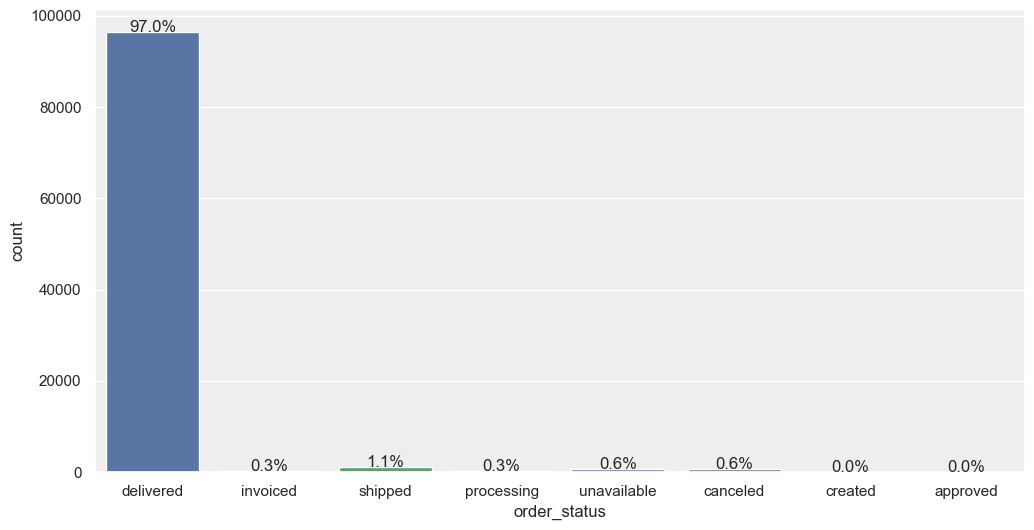

In [42]:
# Merge olist_orders and olist_customer DataFrames
df_orders = olist_orders.merge(olist_customer, on='customer_id', how='left')

# Create a plot to visualize order_status
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.countplot(x='order_status', data=df_orders)

# Calculate the total number of orders
total_orders = df_orders.shape[0]

# Add data labels with the percentage of the total
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            '{:.1f}%'.format(100 * height / total_orders),
            ha="center")

plt.show()

In [43]:
# Calculate the count of each order_status
order_status_count = df_orders['order_status'].value_counts().reset_index()
order_status_count.columns = ['order_status', 'count']

# Calculate the percentage of each order_status
order_status_count['percentage'] = (order_status_count['count'] / df_orders.shape[0]) * 100

# Display the count as a table
order_status_count.style.hide_index()

C:\Users\Achala\AppData\Local\Temp\ipykernel_13132\4007913605.py:9: FutureWarning:

this method is deprecated in favour of `Styler.hide(axis='index')`



The highest amount of orders came from delivered ones. Only 3% of all orders came from the other status such as canceled,
shipped etc.

___
* _Can identify any growing trend on e-commerce in Brazil?_
___

In the following visualization part, a closer look will be taken at the actual growth of e-commerce in terms of purchase orders. To accomplish this, certain information must be extracted from the order_purchase_timestamp, addressing the following aspects:

1. Convert timestamp columns;
2. Derive time attributes from these datetime columns (year, month, day, day of the week, and hour);
3. Assess the e-commerce landscape utilizing these attributes.

In [44]:
# Converting the data type for date columns
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])

# Defining a function to extract various attributes from the timestamp
def extract_time_attributes(df, timestamp_col):
    df[f'{timestamp_col}_year'] = df[timestamp_col].dt.year
    df[f'{timestamp_col}_month'] = df[timestamp_col].dt.month
    df[f'{timestamp_col}_month_name'] = df[timestamp_col].dt.strftime('%b')
    df[f'{timestamp_col}_year_month'] = df[timestamp_col].dt.strftime('%Y%m')
    df[f'{timestamp_col}_date'] = df[timestamp_col].dt.strftime('%Y%m%d')
    df[f'{timestamp_col}_day'] = df[timestamp_col].dt.day
    df[f'{timestamp_col}_dayofweek'] = df[timestamp_col].dt.dayofweek
    df[f'{timestamp_col}_dayofweek_name'] = df[timestamp_col].dt.strftime('%a')
    df[f'{timestamp_col}_hour'] = df[timestamp_col].dt.hour
    hours_bins = [-0.1, 6, 12, 18, 23]
    hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
    df[f'{timestamp_col}_time_day'] = pd.cut(df[f'{timestamp_col}_hour'], hours_bins, labels=hours_labels)

# Applying the function to 'order_purchase_timestamp'
extract_time_attributes(df_orders, 'order_purchase_timestamp')

# Display the transformed DataFrame
df_orders.head()

order_id                       customer_id order_status order_purchase_timestamp   order_approved_at order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date                customer_unique_id  customer_zip_code_prefix            customer_city customer_state  order_purchase_timestamp_year  order_purchase_timestamp_month order_purchase_timestamp_month_name order_purchase_timestamp_year_month order_purchase_timestamp_date  order_purchase_timestamp_day  order_purchase_timestamp_dayofweek order_purchase_timestamp_dayofweek_name  order_purchase_timestamp_hour order_purchase_timestamp_time_day
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15          2017-10-04 19:55:00           2017-10-10 21:25:13                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff                      3149                sao paulo             SP                           2017                              10                                 Oct                              201710                      20171002                             2                                   0                                     Mon                             10                           Morning
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27          2018-07-26 14:31:00           2018-08-07 15:27:45                    2018-08-13  af07308b275d755c9edb36a90c618231                     47813                barreiras             BA                           2018                               7                                 Jul                              201807                      20180724                            24                                   1                                     Tue                             20                             Night
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23          2018-08-08 13:50:00           2018-08-17 18:06:29                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8                     75265               vianopolis             GO                           2018                               8                                 Aug                              201808                      20180808                             8                                   2                                     Wed                              8                           Morning
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59          2017-11-22 13:39:59           2017-12-02 00:28:42                    2017-12-15  7c142cf63193a1473d2e66489a9ae977                     59296  sao goncalo do amarante             RN                           2017                              11                                 Nov                              201711                      20171118                            18                                   5                                     Sat                             19                             Night
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29          2018-02-14 19:46:34           2018-02-16 18:17:02                    2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6                      9195              santo andre             SP                           2018                               2                                 Feb                              201802                      20180213                            13                                   1                                     Tue                             21                             Night

A comprehensive analysis of the number of orders in Brazilian e-commerce during the dataset's period can now be conducted. To achieve this, three graphs will be created using a GridSpec to address the following inquiries:

1. Does Brazilian e-commerce exhibit any growth trends?
2. On which day of the week do Brazilian customers typically make online purchases?
3. At what time of day do Brazilian customers usually shop (Dawn, Morning, Afternoon, or Night)?

C:\Users\Achala\AppData\Local\Temp\ipykernel_13132\361817508.py:21: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\Achala\AppData\Local\Temp\ipykernel_13132\361817508.py:63: UserWarning:

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.



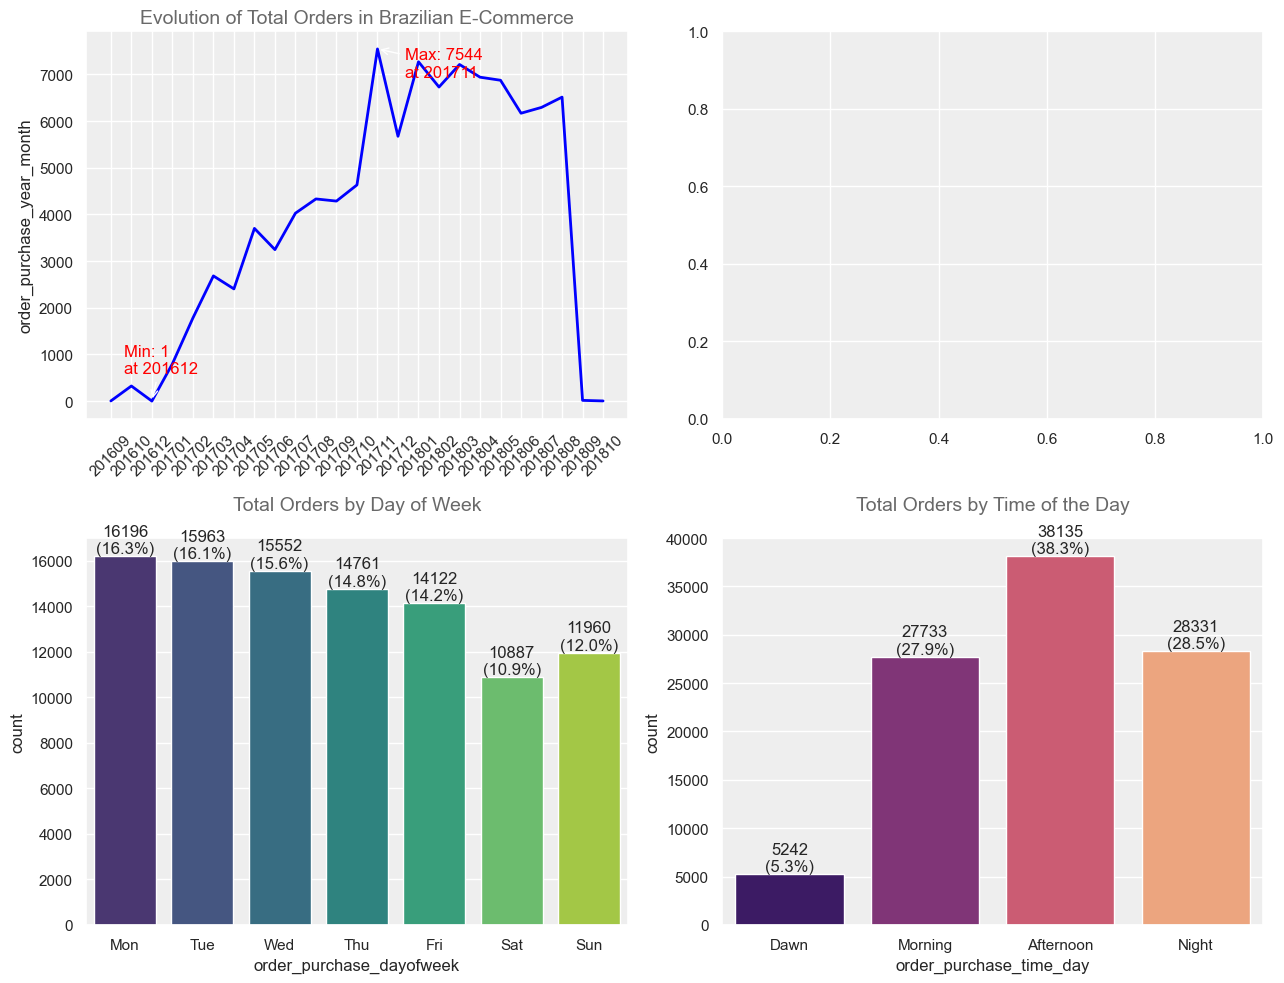

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create 'order_purchase_year_month' column
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))

# Add 'order_purchase_hour', 'order_purchase_dayofweek', and 'order_purchase_time_day' columns
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)

hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# Create a figure and set up the grid
fig, axes = plt.subplots(2, 2, figsize=(13, 10), constrained_layout=True)

# Lineplot - Evolution of e-commerce orders along time
data = df_orders['order_purchase_year_month'].value_counts().sort_index()
sns.lineplot(data=data, ax=axes[0, 0], color='blue', linewidth=2)
axes[0, 0].set_xticklabels(data.index, rotation=45)
axes[0, 0].set_title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')

# Annotations for max and min values
max_value = data.max()
min_value = data.min()
max_index = data.idxmax()
min_index = data.idxmin()
axes[0, 0].annotate(f'Max: {max_value}\nat {max_index}', xy=(max_index, max_value), xytext=(20, -20),
                   textcoords='offset points', arrowprops=dict(arrowstyle='->'), color='red')
axes[0, 0].annotate(f'Min: {min_value}\nat {min_index}', xy=(min_index, min_value), xytext=(-20, 20),
                   textcoords='offset points', arrowprops=dict(arrowstyle='->'), color='red')

# Barchart - Total of orders by day of week
ax = sns.countplot(data=df_orders, x='order_purchase_dayofweek', ax=axes[1, 0], palette='viridis')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1, 0].set_xticklabels(weekday_label)
axes[1, 0].set_title('Total Orders by Day of Week', size=14, color='dimgrey', pad=20)

# Annotations for count and percentage of total
total_count = len(df_orders)
for p in ax.patches:
    count = p.get_height()
    pct = 100 * count / total_count
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{count}\n({pct:.1f}%)', (x, y), ha='center', va='bottom')


# Barchart - Total of orders by time of the day
ax = sns.countplot(data=df_orders, x='order_purchase_time_day', ax=axes[1, 1], palette='magma')
axes[1, 1].set_title('Total Orders by Time of the Day', size=14, color='dimgrey', pad=20)

# Annotations for count and percentage of total
total_count = len(df_orders)
for p in ax.patches:
    count = p.get_height()
    pct = 100 * count / total_count
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{count}\n({pct:.1f}%)', (x, y), ha='center', va='bottom')

plt.tight_layout()
plt.show()                                                                    

From the above chart, following conclusions can be drown:

1. E-commerce in Brazil has been experiencing consistent growth over time. There is some seasonality with spikes during specific months, but overall, there is a clear indication that customers are increasingly inclined to shop online.

2. Brazilians prefer to make purchases on Mondays, with a higher propensity for shopping during the afternoon hours.

3. Note that there is a significant drop in orders between August 2018 and September 2018. This could potentially be due to data inconsistencies. To ensure a more accurate comparison between 2017 and 2018, let's try to consider only orders placed from January to August in both years.

___
* _E-commerce: a comparison between 2017 and 2018_
___

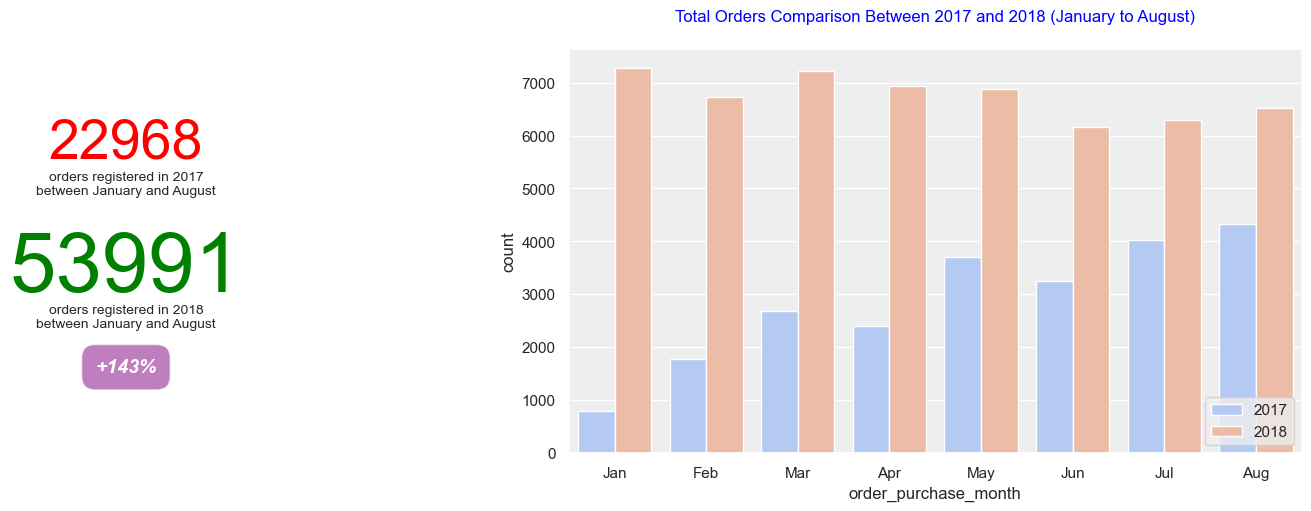

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].dt.year
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].dt.month

# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(13, 5))

# Axis definition
gs = plt.GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

# Annotation - Growth in e-commerce orders between 2017 and 2018
df_orders_compare = df_orders.query('order_purchase_year in (2017, 2018) & order_purchase_month <= 8')
year_orders = df_orders_compare['order_purchase_year'].value_counts()
growth = int(round(100 * (1 + year_orders[2017] / year_orders[2018]), 0))
ax1.text(0.00, 0.73, f'{year_orders[2017]}', fontsize=40, color='red', ha='center')
ax1.text(0.00, 0.64, 'orders registered in 2017\nbetween January and August', fontsize=10, ha='center')
ax1.text(0.00, 0.40, f'{year_orders[2018]}', fontsize=60, color='green', ha='center')
ax1.text(0.00, 0.31, 'orders registered in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax1.text(0.00, 0.20, f'{signal}{growth}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='purple', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax1.axis('off')

# Bar chart - Comparison between monthly sales between 2017 and 2018
sns.countplot(data=df_orders_compare, x='order_purchase_month', hue='order_purchase_year', ax=ax2, palette='coolwarm')
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
ax2.set_xticklabels(month_label)
ax2.set_title('Total Orders Comparison Between 2017 and 2018 (January to August)', size=12, color='blue', pad=20)
plt.legend(loc='lower right')
plt.show()

<a id="3.2"></a>
<font color="dimgrey" size=+2.0><b>3.2 E-Commerce Variation Around Brazil</b></font>

To ready the data for a comprehensive assessment of e-commerce in Brazilian states, these procedures will be implemented:

1. Combine order and order_item information;
2. Utilize a Brazilian government API to determine the region corresponding to each customer_state;
3. Generate insightful visualizations to address pertinent business inquiries.

In [47]:
# Merge orders and order_items data
df_orders_items = df_orders.merge(olist_order_items, on='order_id', how='left')

# Obtain region data using the API
response = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
region_data = [region['UF'] for region in json.loads(response.text)]
br_regions = pd.DataFrame(region_data)
br_regions['region_name'] = br_regions['regiao'].apply(lambda x: x['nome'])
br_regions.drop('regiao', axis=1, inplace=True)
br_regions.drop_duplicates(inplace=True)

# Filter geolocations within Brazil's borders
geo_filtered = olist_geolocation[olist_geolocation.geolocation_lat <= 5.27438888]
geo_filtered = geo_filtered[geo_filtered.geolocation_lng >= -73.98283055]
geo_filtered = geo_filtered[geo_filtered.geolocation_lat >= -33.75116944]
geo_filtered = geo_filtered[geo_filtered.geolocation_lng <= -34.79314722]
geo_grouped = geo_filtered.groupby('geolocation_zip_code_prefix', as_index=False).min()

# Make sure the joining columns have the same data type
df_orders_items['customer_state'] = df_orders_items['customer_state'].astype(str)
br_regions['sigla'] = br_regions['sigla'].astype(str)
df_orders_items['customer_zip_code_prefix'] = df_orders_items['customer_zip_code_prefix'].astype(int)
geo_grouped['geolocation_zip_code_prefix'] = geo_grouped['geolocation_zip_code_prefix'].astype(int)

# Combine all information
df_orders_items = df_orders_items.merge(br_regions, how='left', left_on='customer_state', right_on='sigla')
df_orders_items = df_orders_items.merge(geo_grouped, how='left', left_on='customer_zip_code_prefix', 
                                        right_on='geolocation_zip_code_prefix')
df_orders_items.head()

order_id                       customer_id order_status order_purchase_timestamp   order_approved_at order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date                customer_unique_id  customer_zip_code_prefix            customer_city customer_state  order_purchase_timestamp_year  order_purchase_timestamp_month order_purchase_timestamp_month_name order_purchase_timestamp_year_month order_purchase_timestamp_date  order_purchase_timestamp_day  order_purchase_timestamp_dayofweek order_purchase_timestamp_dayofweek_name  order_purchase_timestamp_hour order_purchase_timestamp_time_day order_purchase_year_month  order_purchase_hour  order_purchase_dayofweek order_purchase_time_day  order_purchase_year  order_purchase_month  order_item_id                        product_id                         seller_id  shipping_limit_date   price  freight_value  id sigla                 nome   region_name  geolocation_zip_code_prefix  geolocation_lat  geolocation_lng         geolocation_city geolocation_state
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15          2017-10-04 19:55:00           2017-10-10 21:25:13                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff                      3149                sao paulo             SP                           2017                              10                                 Oct                              201710                      20171002                             2                                   0                                     Mon                             10                           Morning                    201710                   10                         0                 Morning                 2017                    10            1.0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9  2017-10-06 11:07:15   29.99           8.72  35    SP            São Paulo       Sudeste                       3149.0       -23.583885       -46.587473                sao paulo                SP
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27          2018-07-26 14:31:00           2018-08-07 15:27:45                    2018-08-13  af07308b275d755c9edb36a90c618231                     47813                barreiras             BA                           2018                               7                                 Jul                              201807                      20180724                            24                                   1                                     Tue                             20                             Night                    201807                   20                         1                   Night                 2018                     7            1.0  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962  2018-07-30 03:24:27  118.70          22.76  29    BA                Bahia      Nordeste                      47813.0       -12.945892       -45.016313                barreiras                BA
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23          2018-08-08 13:50:00           2018-08-17 18:06:29                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8                     75265               vianopolis             GO                           2018                               8                                 Aug                              201808                      20180808                             8                                   2                                     Wed                              8                           Morning                    201808                    8                         2                 Morning                 2018                     8            1.0  aa438

___
* _An overview of customer's order by region, state and city_
___

In [48]:
# Filter data between 201701 and 201808
df_orders_filtered = df_orders_items[(df_orders_items['order_purchase_year_month'].astype(int) >= 201701)]
df_orders_filtered = df_orders_filtered[(df_orders_filtered['order_purchase_year_month'].astype(int) <= 201808)]

# Group data by region
regional_group = df_orders_filtered.groupby(['order_purchase_year_month', 'region_name'], as_index=False)
regional_group = regional_group.agg({'customer_id': 'count', 'price': 'sum'}).sort_values(by='order_purchase_year_month')
regional_group.columns = ['month', 'region', 'order_count', 'order_amount']
regional_group.reset_index(drop=True, inplace=True)

# Group data by city (top 10)
city_group = df_orders_filtered.groupby('geolocation_city', as_index=False).count().loc[:, ['geolocation_city', 'order_id']]
city_group = city_group.sort_values(by='order_id', ascending=False).reset_index(drop=True)
city_group = city_group.iloc[:10, :]

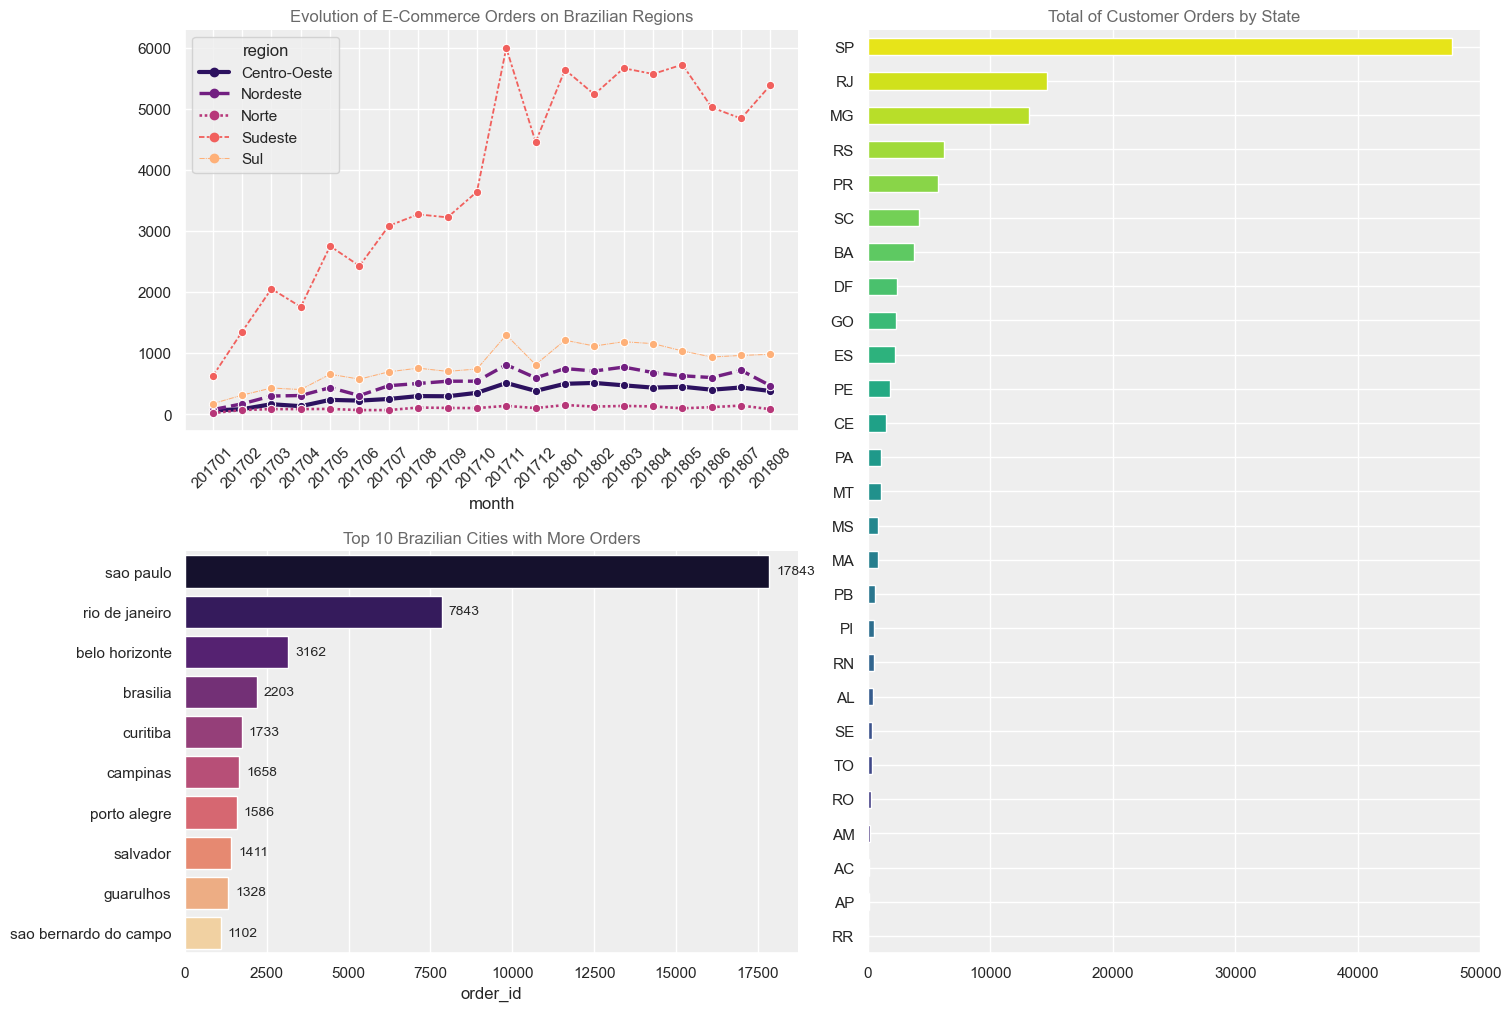

In [49]:
# Import necessary libraries
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Creating and preparing figure and axes
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

# Count of orders by region
sns.lineplot(x='month', y='order_count', ax=ax1, data=regional_group, hue='region', 
             size='region', style='region', palette='magma', markers=['o'] * 5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title('Evolution of E-Commerce Orders on Brazilian Regions', size=12, color='dimgrey')
ax1.set_ylabel('')
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

# Top cities with more customer orders in Brazil
city_barplot = sns.barplot(y='geolocation_city', x='order_id', data=city_group, ax=ax2, palette='magma')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_title('Top 10 Brazilian Cities with More Orders', size=12, color='dimgrey')
ax2.set_ylabel('')

# Annotate the bars with the number of orders
for p in city_barplot.patches:
    city_barplot.annotate(format(p.get_width(), '.0f'), 
                   (p.get_width(), p.get_y() + p.get_height() / 2),
                   ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontsize=10)

# Total orders by state
state_order_count = df_orders_filtered['customer_state'].value_counts().sort_values(ascending=True)
state_order_count.plot(kind='barh', ax=ax3, color=sns.color_palette("viridis", len(state_order_count)))
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_title('Total of Customer Orders by State', size=12, color='dimgrey')
ax3.set_ylabel('')

plt.show()

___
* _How customers are distributed in Brazil? (a 30k orders sample from 2018 in a map)_
___

In [50]:
# Import necessary libraries
import folium
from folium.plugins import FastMarkerCluster

# Zipping locations
lats = list(df_orders_filtered.query('order_purchase_year == 2018')['geolocation_lat'].dropna().values)[:30000]
longs = list(df_orders_filtered.query('order_purchase_year == 2018')['geolocation_lng'].dropna().values)[:30000]
locations = list(zip(lats, longs))

# Creating a map using folium
map1 = folium.Map(location=[-15, -50], zoom_start=4.0)

# Plugin: FastMarkerCluster
FastMarkerCluster(data=locations).add_to(map1)

map1

___
* _**HeatMaps:** a good view to see where are the core of brazilian e-commerce customers_
___

Using the map displayed earlier, it is possible to deduce that the southeastern region of Brazil has the highest volume of e-commerce orders. Now, let's visualize this data with a HeatMap!

In [51]:
# Import necessary libraries
import folium
from folium.plugins import HeatMap

# Grouping geolocation data for plotting a heatmap
heatmap_data = df_orders_filtered.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count().iloc[:, :3]

# Creating a map using folium
heatmap_map = folium.Map(
    location=[-15, -50], 
    zoom_start=4.0, 
    tiles='cartodbdark_matter'
)

# Plugin: HeatMap
HeatMap(
    name='Heatmap',
    data=heatmap_data,
    radius=10,
    max_zoom=13
).add_to(heatmap_map)

heatmap_map

Below graph display the evolution of e-commerce orders among time by using  folium plugin [HeatMapWithTime](https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/HeatMapWithTime.ipynb)

In [52]:
# Import necessary libraries
import folium
from folium.plugins import HeatMapWithTime

# Preparing data for heatmap with time
epoch_list = []
heatmap_evl_data = df_orders_filtered[(df_orders_filtered['order_purchase_year_month'].astype(int) >= 201801)]
heatmap_evl_data = heatmap_evl_data[(heatmap_evl_data['order_purchase_year_month'].astype(int) <= 201807)]
time_index = heatmap_evl_data['order_purchase_year_month'].sort_values().unique()

for epoch in time_index:
    data_temp = heatmap_evl_data.query('order_purchase_year_month == @epoch')
    data_temp = data_temp.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count()
    data_temp = data_temp.sort_values(by='order_id', ascending=False).iloc[:, :3]
    epoch_list.append(data_temp.values.tolist())

# Creating a map using folium
time_map = folium.Map(
    location=[-15, -50],
    zoom_start=4.0,
    tiles='cartodbdark_matter'
)

# Plugin: HeatMapWithTime
HeatMapWithTime(
    name='Evolution of Orders in a Geolocation Perspective',
    data=epoch_list,
    radius=10,
    index=list(time_index)
).add_to(time_map)

time_map

<a id="3.3"></a>
<font color="dimgrey" size=+2.0><b>3.3 E-Commerce Impact on Economy</b></font>

Thus far, the analysis of the e-commerce landscape has focused on the quantity of orders received. Volume by month, day of the week, time of day, and even geographic location has been examined.

Moving forward, the focus will shift to the financial aspects of e-commerce, exploring order prices, shipping costs, and other related factors.

___
* _How about the e-commerce sales? Did they grow up over time?_
___

To address this question, the data will first be grouped in a manner that allows for an examination of the overall evolution.

In [53]:
# Grouping data
orders_grouped = df_orders_filtered.groupby(by=['order_purchase_year', 'order_purchase_year_month'], as_index=False)
orders_aggregated = orders_grouped.agg({
    'order_id': 'count',
    'price': 'sum',
    'freight_value': 'sum'
})

# Adding new columns for analysis
orders_aggregated['avg_price_per_order'] = orders_aggregated['price'] / orders_aggregated['order_id']
orders_aggregated['avg_freight_per_order'] = orders_aggregated['freight_value'] / orders_aggregated['order_id']
orders_aggregated.head()

order_purchase_year order_purchase_year_month  order_id      price  freight_value  avg_price_per_order  avg_freight_per_order
0                 2017                    201701       966  120312.87       16875.62           124.547484              17.469586
1                 2017                    201702      1998  247303.02       38977.60           123.775285              19.508308
2                 2017                    201703      3041  374344.30       57704.29           123.099079              18.975432
3                 2017                    201704      2697  359927.23       52495.01           133.454664              19.464223
4                 2017                    201705      4176  506071.14       80119.81           121.185618              19.185778

C:\Users\Achala\AppData\Local\Temp\ipykernel_13132\2175621579.py:57: UserWarning:

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.



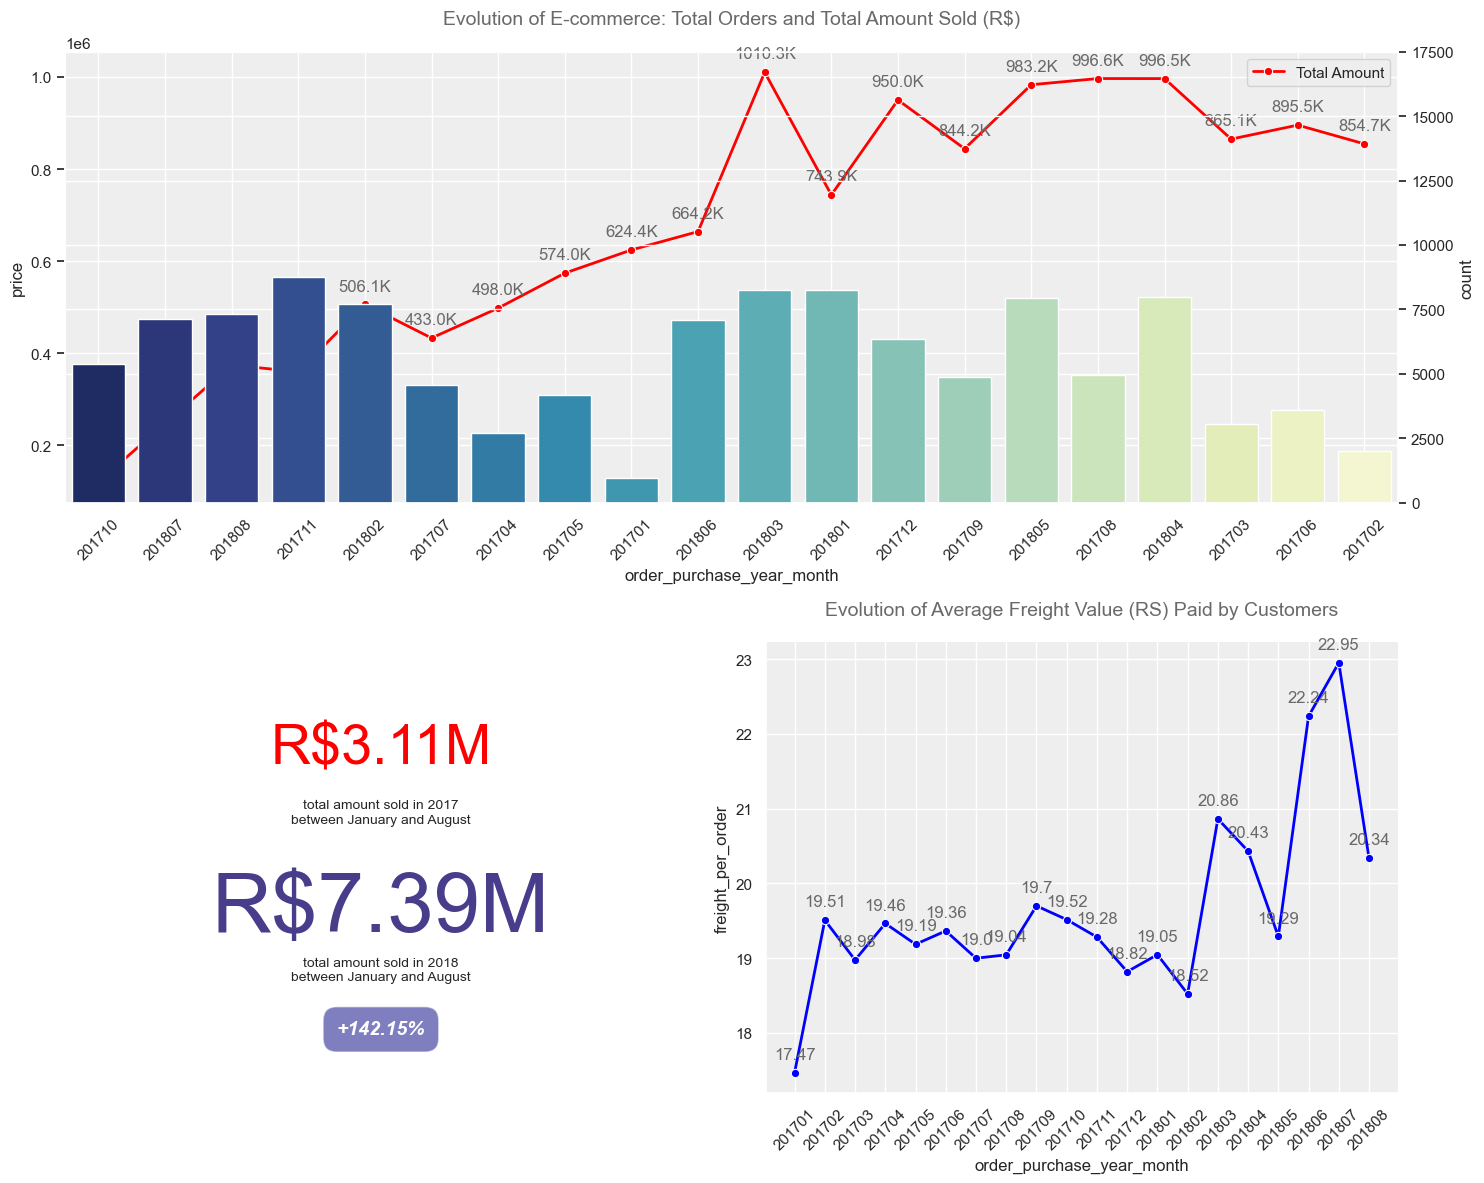

In [54]:
orders_aggregated['freight_per_order'] = orders_aggregated['freight_value'] / orders_aggregated['order_id']

# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Plot 1 - Evolution of total orders and total sales on e-commerce
sns.lineplot(x='order_purchase_year_month', y='price', ax=ax1, data=orders_aggregated, linewidth=2, 
             color='red', marker='o', label='Total Amount')
ax1_twx = ax1.twinx()
sns.countplot(x='order_purchase_year_month', data=df_orders_filtered, ax=ax1_twx, palette='YlGnBu_r')
ax1_twx.set_yticks(np.arange(0, 20000, 2500))

# Customizing the first plot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
for x, y in orders_aggregated.price.items():
    ax1.annotate(str(round(y/1000, 1))+'K', xy=(x, y), textcoords='offset points', xytext=(0, 10),
                ha='center', color='dimgrey')
ax1.set_title('Evolution of E-commerce: Total Orders and Total Amount Sold (R$)', size=14, color='dimgrey', pad=20)

# Plot 2 - Big Numbers of Sales Evolution
month_comparison = ['201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708',
                    '201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808']
sales_comparison = orders_aggregated.query('order_purchase_year_month in (@month_comparison)')
sold_2017 = sales_comparison.query('order_purchase_year == 2017')['price'].sum()
sold_2018 = sales_comparison.query('order_purchase_year == 2018')['price'].sum()
growth = 1 + (sold_2017 / sold_2018)
ax2.text(0.50, 0.73, 'R$' + str(round(sold_2017/1000000, 2)) + 'M', fontsize=40, color='red', ha='center')
ax2.text(0.50, 0.60, 'total amount sold in 2017\nbetween January and August', fontsize=10, ha='center')
ax2.text(0.50, 0.36, 'R$' + str(round(sold_2018/1000000, 2)) + 'M', fontsize=60, color='darkslateblue', ha='center')
ax2.text(0.50, 0.25, 'total amount sold in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax2.text(0.50, 0.13, f'{signal}{str(round(100 * growth, 2))}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax2.axis('off')

# Plot 3 - Evolution of mean freight value paid by the customers
sns.lineplot(x='order_purchase_year_month', y='freight_per_order', data=orders_aggregated, linewidth=2, 
             color='blue', marker='o', ax=ax3)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
for tick in ax3.get_xticklabels():
    tick.set_rotation(45)
for x, y in orders_aggregated.freight_per_order.items():
    ax3.annotate(round(y, 2), xy=(x, y), textcoords='offset points', xytext=(0, 10),
                ha='center', color='dimgrey')
ax3.set_title('Evolution of Average Freight Value (RS) Paid by Customers', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

___
* _How the total sales (sum of price) are concentraded in brazilian states?_
___

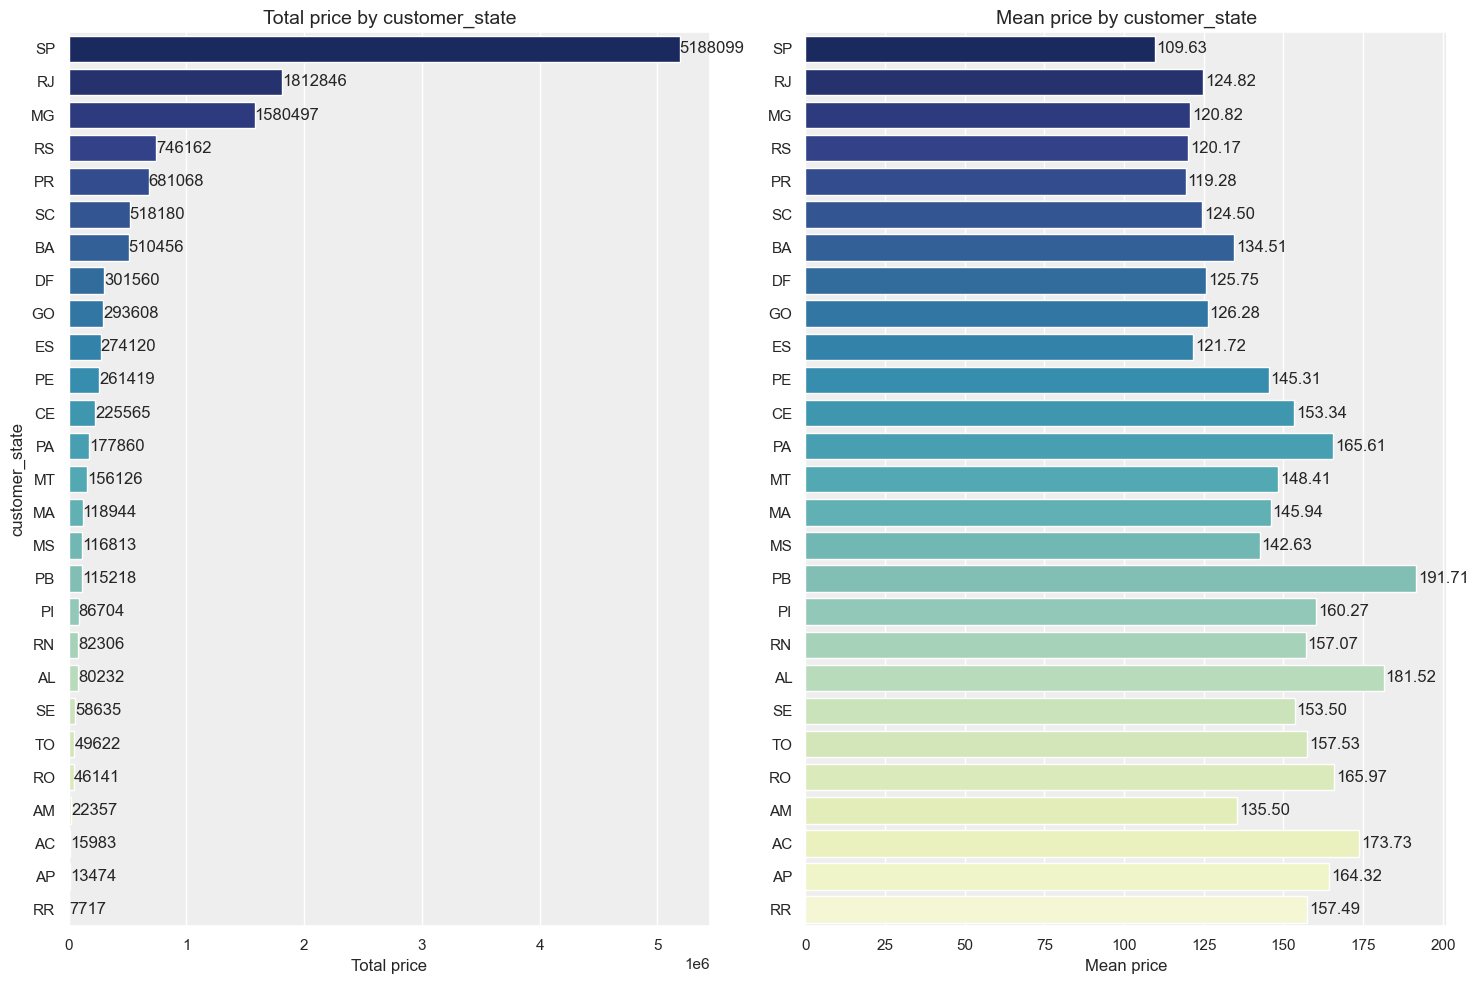

In [55]:
def mean_sum_analysis(data, groupby_col, value_col, palette='YlGnBu_r', figsize=(15, 10)):
    grouped = data.groupby(groupby_col)[value_col].agg(['mean', 'sum']).reset_index()
    grouped.sort_values(by='sum', ascending=False, inplace=True)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    sns.barplot(y=groupby_col, x='sum', data=grouped, ax=ax1, palette=palette)
    sns.barplot(y=groupby_col, x='mean', data=grouped, ax=ax2, palette=palette)

    ax1.set_ylabel(groupby_col, fontsize=12)
    ax1.set_xlabel(f'Total {value_col}', fontsize=12)
    ax1.set_title(f'Total {value_col} by {groupby_col}', fontsize=14)

    ax2.set_ylabel(None)
    ax2.set_xlabel(f'Mean {value_col}', fontsize=12)
    ax2.set_title(f'Mean {value_col} by {groupby_col}', fontsize=14)

    for p in ax1.patches:
        width = p.get_width()
        ax1.text(width + 0.5, p.get_y() + p.get_height() / 2, '{:1.0f}'.format(width), ha='left', va='center')

    for p in ax2.patches:
        width = p.get_width()
        ax2.text(width + 0.5, p.get_y() + p.get_height() / 2, '{:1.2f}'.format(width), ha='left', va='center')

    plt.tight_layout()
    plt.show()

mean_sum_analysis(df_orders_filtered, 'customer_state', 'price', palette='YlGnBu_r', figsize=(15, 10))

It's very interesting to observe how a high total amount is sold in some states while maintaining a low price per order. When SP (São Paulo) is examined, for instance, it can be noted that it holds the highest state value for e-commerce (5,188,099 sold). However, it is also the state where the customers pay the least per order (110.00 per order).

How about the freight?

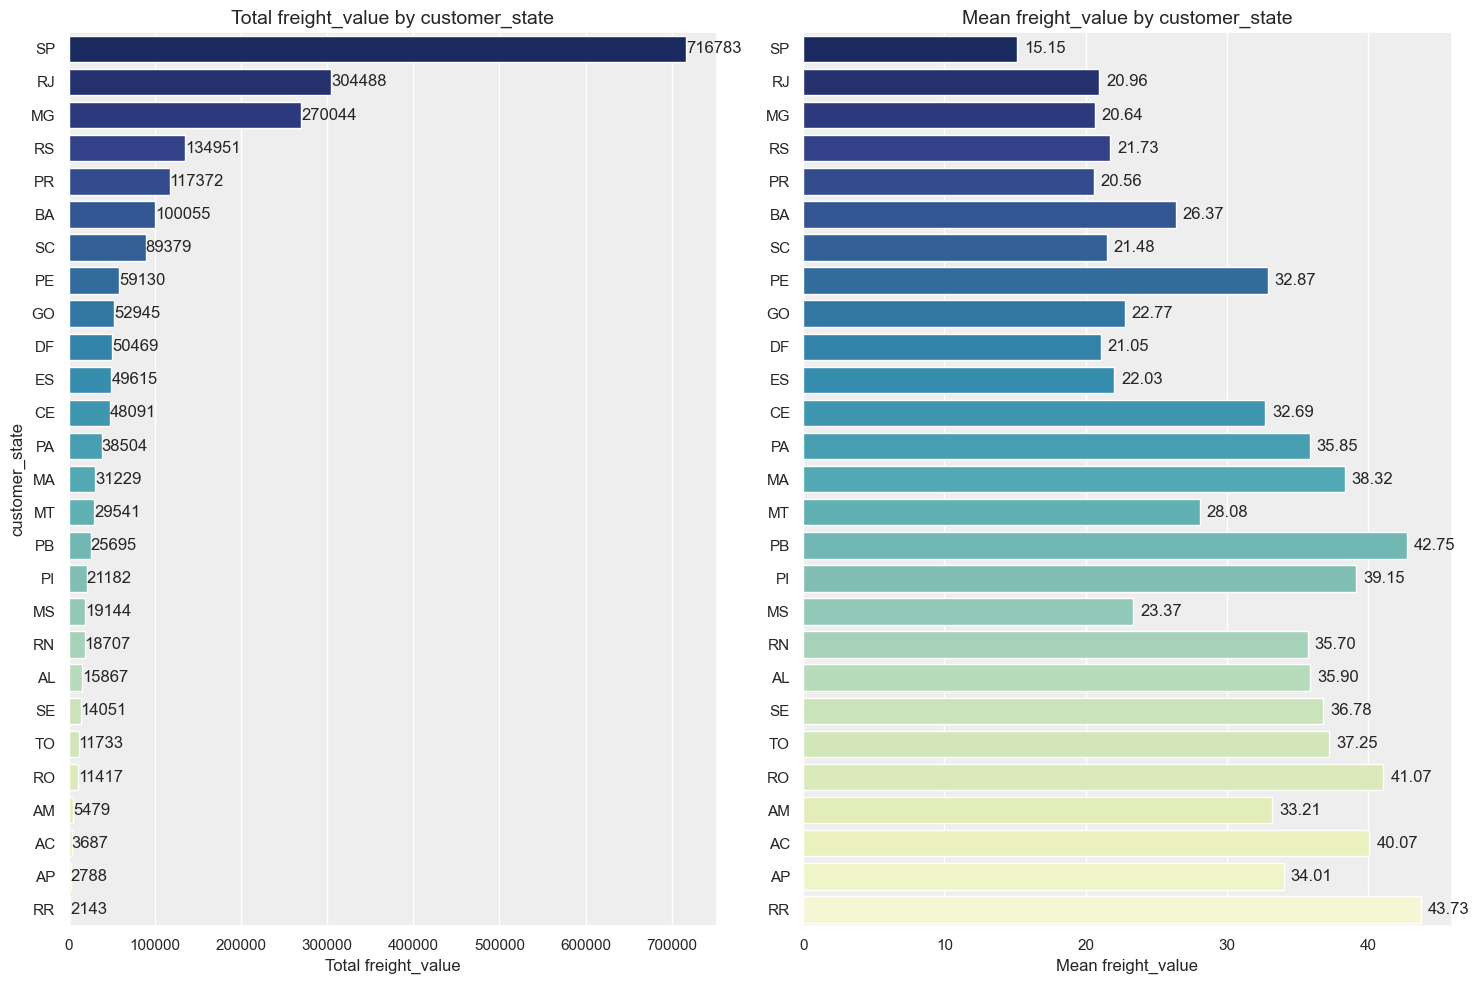

In [56]:
def mean_sum_analysis(data, groupby_col, value_col, palette='YlGnBu_r', figsize=(15, 10)):
    grouped = data.groupby(groupby_col)[value_col].agg(['mean', 'sum']).reset_index()
    grouped.sort_values(by='sum', ascending=False, inplace=True)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    sns.barplot(y=groupby_col, x='sum', data=grouped, ax=ax1, palette=palette)
    sns.barplot(y=groupby_col, x='mean', data=grouped, ax=ax2, palette=palette)

    ax1.set_ylabel(groupby_col, fontsize=12)
    ax1.set_xlabel(f'Total {value_col}', fontsize=12)
    ax1.set_title(f'Total {value_col} by {groupby_col}', fontsize=14)

    ax2.set_ylabel(None)
    ax2.set_xlabel(f'Mean {value_col}', fontsize=12)
    ax2.set_title(f'Mean {value_col} by {groupby_col}', fontsize=14)

    for p in ax1.patches:
        width = p.get_width()
        ax1.text(width + 0.5, p.get_y() + p.get_height() / 2, '{:1.0f}'.format(width), ha='left', va='center')

    for p in ax2.patches:
        width = p.get_width()
        ax2.text(width + 0.5, p.get_y() + p.get_height() / 2, '{:1.2f}'.format(width), ha='left', va='center')

    plt.tight_layout()
    plt.show()

mean_sum_analysis(df_orders_filtered, 'customer_state', 'freight_value', palette='YlGnBu_r', figsize=(15, 10))

Here valuable information can be obtained about the states where customers have to pay the highest mean freight value. For instance, customers in Roraima (RR), Paraíba (PB), Rondônia (RO), and Acre (AC) typically incur higher freight costs compared to those in other states.

<a id="3.4"></a>
<font color="dimgrey" size=+2.0><b>3.4 Payment Type Analysis</b></font>

A dataset providing information regarding payments made for orders has been made available. An examination of the influence that payments may have on e-commerce can be conducted by constructing a mini-dashboard featuring the key concepts of payment types and payment installments. This serves the purpose of presenting sufficient information to shed light on the typical payment preferences of e-commerce buyers.

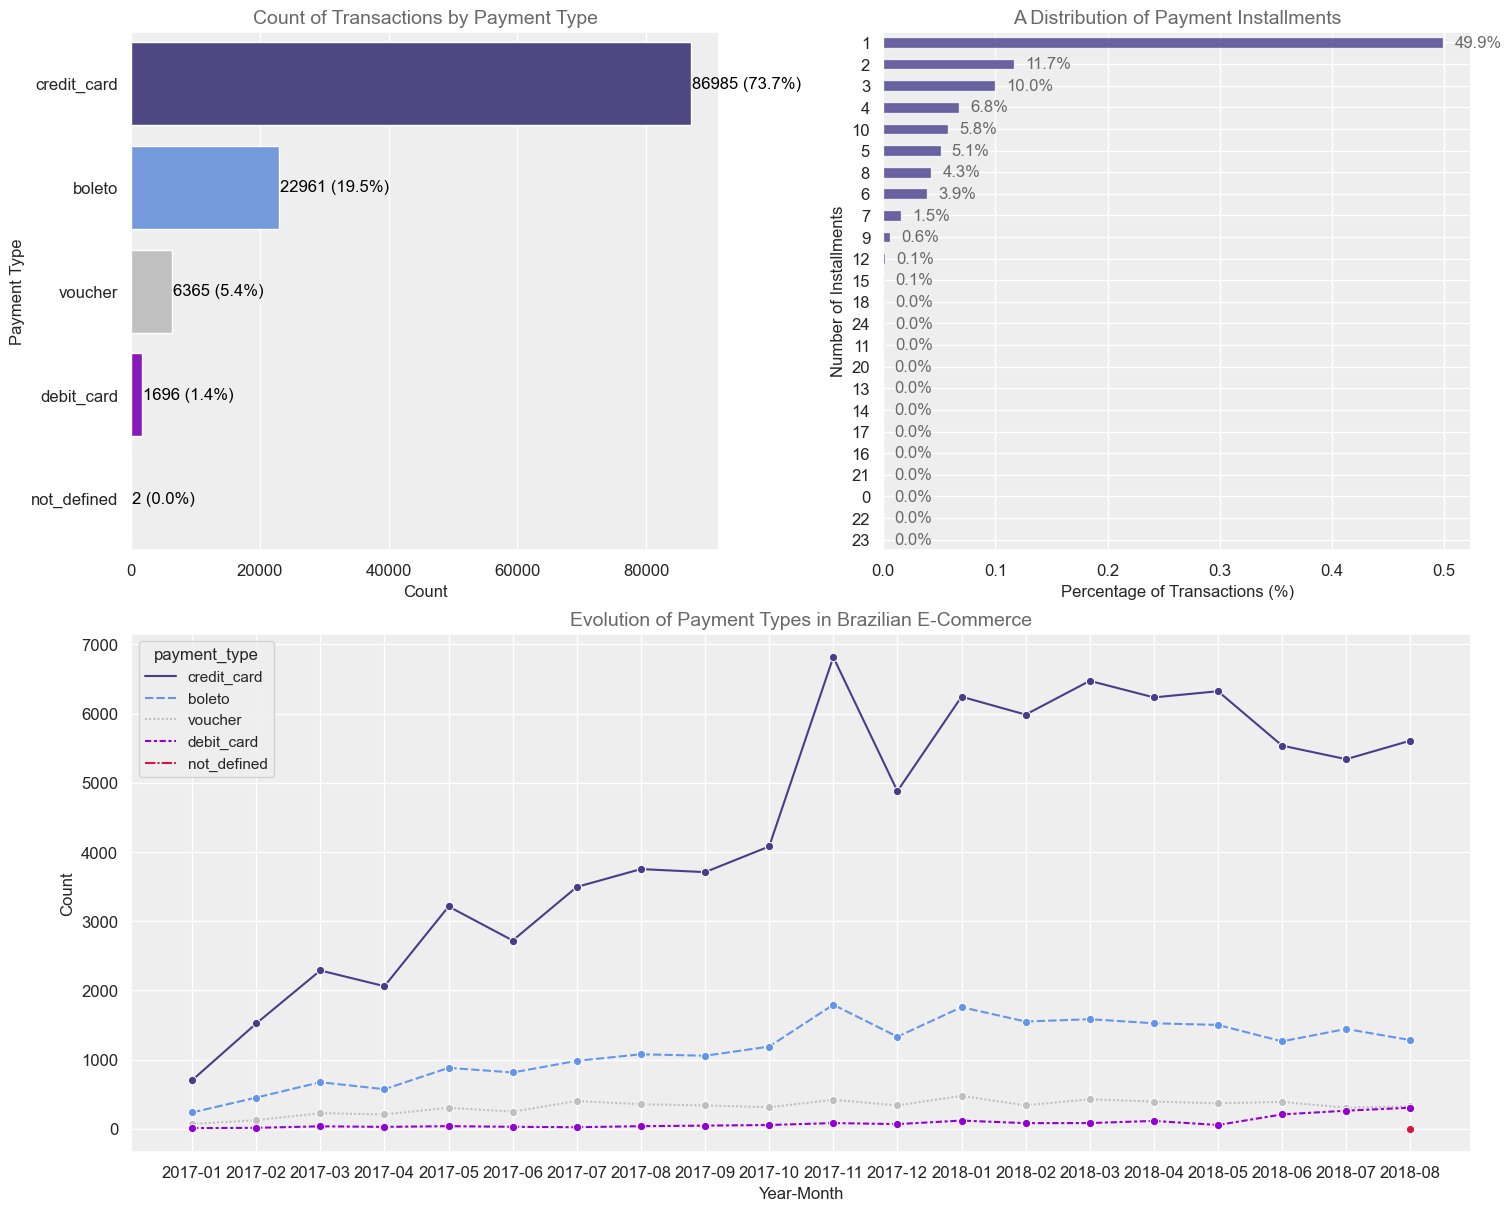

In [57]:
# Importing necessary libraries
from matplotlib.gridspec import GridSpec
from datetime import datetime
from pandas.api.types import CategoricalDtype

# Grouping data
df_orders_pay = df_orders_filtered.merge(olist_order_payments, how='left', on='order_id')

# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])


# Plot 1 - Payment types in a horizontal bar chart
colors = ['darkslateblue', 'cornflowerblue', 'silver', 'darkviolet', 'crimson']
df_pay_type_count = df_orders_pay['payment_type'].value_counts()
df_pay_type_count = df_pay_type_count.sort_values(ascending=False)  # Sort by descending order
total_payments = len(df_orders_pay)

# Calculate percentage of total and create labels
percentages = df_pay_type_count / total_payments * 100
labels = [f'{count} ({percent:.1f}%)' for count, percent in zip(df_pay_type_count, percentages)]

# Create horizontal bar chart
sns.barplot(x=df_pay_type_count.values, y=df_pay_type_count.index, ax=ax1, palette=colors)
ax1.set_title('Count of Transactions by Payment Type', size=14, color='dimgrey')
ax1.set_xlabel('Count', size=12)
ax1.set_ylabel('Payment Type', size=12)
ax1.tick_params(axis='both', labelsize=12)

# Add data labels
for i, v in enumerate(df_pay_type_count.values):
    ax1.text(v + 100, i, labels[i], color='black', fontsize=12, ha='left', va='center')
    
    
# Plot 2 - Payment installments
df_orders_pay['payment_installments'] = pd.Categorical(df_orders_pay['payment_installments'])
df_pay_installments_count = df_orders_pay['payment_installments'].value_counts(normalize=True).sort_values(ascending=True)
df_pay_installments_count.plot.barh(color='darkslateblue', ax=ax2, alpha=0.8)
ax2.set_title('A Distribution of Payment Installments', color='dimgrey', size=14)
ax2.set_xlabel('Percentage of Transactions (%)', size=12)
ax2.set_ylabel('Number of Installments', size=12)
ax2.tick_params(axis='both', labelsize=12)

for i, v in enumerate(df_pay_installments_count):
    ax2.text(v+0.01, i, f'{v*100:.1f}%', color='dimgrey', fontsize=12, va='center')

# Plot 3 - Evolution of payment types
df_orders_pay['order_purchase_timestamp'] = pd.to_datetime(df_orders_pay['order_purchase_timestamp'])
df_orders_pay['order_purchase_year_month'] = df_orders_pay['order_purchase_timestamp'].dt.strftime('%Y-%m')
payment_evl = df_orders_pay.groupby(by=['order_purchase_year_month', 'payment_type'], as_index=False).count()
payment_evl = payment_evl.loc[:, ['order_purchase_year_month', 'payment_type', 'order_id']]
payment_evl = payment_evl.sort_values(by=['order_purchase_year_month', 'order_id'], ascending=[True, False])
sns.lineplot(x='order_purchase_year_month', y='order_id', data=payment_evl, ax=ax3, hue='payment_type',
             style='payment_type', palette=colors, marker='o')
ax3.set_title('Evolution of Payment Types in Brazilian E-Commerce', size=14, color='dimgrey')
ax3.set_xlabel('Year-Month', size=12)
ax3.set_ylabel('Count', size=12)
ax3.tick_params(axis='both', labelsize=12)

plt.show()

It can be observed from the line chart that credit card payments have dominated the Brazilian e-commerce landscape. However, a slight decrease in the usage of this payment method can be seen since March 2018. On the other hand, payments made using debit cards have exhibited an upward trend starting from May 2018, presenting a potential opportunity for investors to enhance their services for such payments.

As depicted in the bar chart, the preferences of Brazilian customers in regards to payment for orders can be seen. The majority of payments are made in a single installment, with a notable number of payments also being made in 10 installments.

# 4. Analysis of Olist's Customer Reviews with help of NLP 

In this section, an analysis of the Olist E-Commerce dataset will be conducted with the aim of extracting value from customer reviews. Satisfaction surveys, which are generated and dispatched via email to customers either upon receipt of the product or when the estimated delivery date is reached, will be the focus of this analysis. Each customer experience is rated on a scale of 1 to 5, and accompanying comments may also be provided.

In [61]:
#Importing Libraries
import random
from PIL import Image
from datetime import datetime
import unicodedata

import numpy as np
import pandas as pd
import nltk
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

Ease of identification of 1 and 5 star reviews during the analysis has been facilitated by the selection of a red/blue diverging color palette. This choice of colors is intended to be colorblind safe.

In [65]:
sns.set()

# A color blind safe palette that goes well with the background
COLOR_5S = '#0571b0'
COLOR_1S = '#ca0020'
REVIEWS_PALETTE = sns.color_palette((COLOR_1S, '#d57b6f', '#c6c6c6', '#7f9abc', COLOR_5S))

# Lighter background to help with review categories' colors
sns.set_style('darkgrid', {'axes.facecolor': '#eeeeee'})

# Default figure size
resize_plot = lambda: plt.gcf().set_size_inches(12, 5)

In [66]:
orders = pd.read_csv('D:/DS PROJECT/Datasets/olist_orders_dataset.csv')
reviews = pd.read_csv('D:/DS PROJECT/Datasets/olist_order_reviews_dataset.csv')

# Convert columns to datetime
reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'], format='%Y/%m/%d %H:%M:%S')
reviews['review_answer_timestamp'] = pd.to_datetime(reviews['review_answer_timestamp'], format='%Y/%m/%d %H:%M:%S')
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], format='%Y/%m/%d %H:%M:%S')
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'], format='%Y/%m/%d %H:%M:%S')

# Merge with orders
reviews = pd.merge(reviews, orders, on='order_id')

# Remove unused columns
to_drop = [
    'review_id', 
    'order_id', 
    'customer_id', 
    'review_comment_title', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_estimated_delivery_date'
]
reviews.drop(columns=to_drop, inplace=True)

In [67]:
reviews.head()

review_score                             review_comment_message review_creation_date review_answer_timestamp order_status order_purchase_timestamp order_delivered_customer_date
0             4                                                NaN           2018-01-18     2018-01-18 21:46:59    delivered      2018-01-11 15:30:49           2018-01-17 18:42:41
1             5                                                NaN           2018-03-10     2018-03-11 03:05:13    delivered      2018-02-28 12:25:19           2018-03-09 23:17:20
2             5                                                NaN           2018-02-17     2018-02-18 14:36:24    delivered      2018-02-03 09:56:22           2018-02-16 17:28:48
3             5              Recebi bem antes do prazo estipulado.           2017-04-21     2017-04-21 22:02:06    delivered      2017-04-09 17:41:13           2017-04-20 09:08:35
4             5  Parabéns lojas lannister adorei comprar pela I...           2018-03-01     2018-03-02 10:26:53    delivered      2018-02-10 10:59:03           2018-02-28 16:33:35

There's 100K reviews on this dataframe, with an average of 4.1 stars.

In [68]:
total_reviews = len(reviews)
p_5s = len(reviews[reviews['review_score'] == 5]) / total_reviews * 100
p_1s = len(reviews[reviews['review_score'] == 1]) / total_reviews * 100
first_dt = reviews['review_creation_date'].min()
last_dt = reviews['review_creation_date'].max()
avg_s = reviews['review_score'].mean()

print(f'Total number of reviews: {total_reviews}')
print(f'First review date: {first_dt}')
print(f'Last review date: {last_dt}')
print(f'Percentage of 5-star reviews: {p_5s:.1f}%')
print(f'Percentage of 1-star reviews: {p_1s:.1f}%')
print(f'Average review score: {avg_s:.1f} stars')

Total number of reviews: 99224
First review date: 2016-10-02 00:00:00
Last review date: 2018-08-31 00:00:00
Percentage of 5-star reviews: 57.8%
Percentage of 1-star reviews: 11.5%
Average review score: 4.1 stars


99224 reviews from 2016-10 to 2018-08 with an average rating of 4.1 stars. 57.8% 5-star and 11.5% 1-star reviews.

It is clear that there is considerable amount of 1 star, and more than 50% of reviews are 5-star reviews

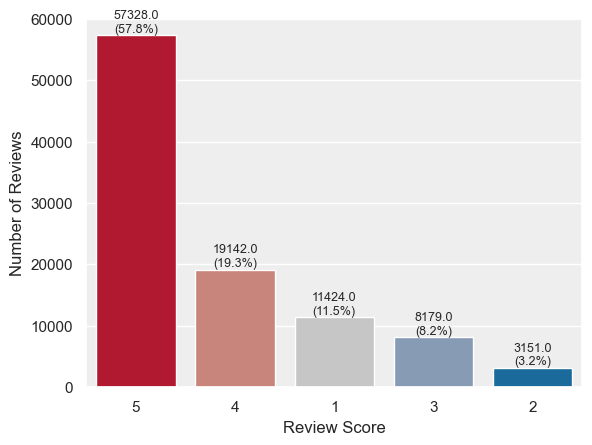

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 'reviews' is a DataFrame with a column named 'review_score'
review_counts = reviews['review_score'].value_counts(normalize=True).reset_index()
review_counts.columns = ['review_score', 'proportion']

review_counts['count'] = reviews['review_score'].value_counts().values
total_reviews = review_counts['count'].sum()

# Create the barplot
ax = sns.barplot(x='review_score', y='count', data=review_counts, palette=REVIEWS_PALETTE, order=review_counts['review_score'])

# Add data labels and percentages
for index, row in review_counts.iterrows():
    ax.text(index, row['count'], f"{row['count']}\n({row['proportion']*100:.1f}%)", ha='center', va='bottom', fontsize=9)

# Set labels
ax.set_xlabel('Review Score')
ax.set_ylabel('Number of Reviews')

# Show the plot
plt.show()


It is anticipated that reviews would be generated following the respective purchases; however, the dataset contains some negative values for the review creation delay (were reviews sent to customers prior to the purchases occurring?). Thankfully, the majority of reviews were dispatched to customers several days after the purchases, as initially anticipated.

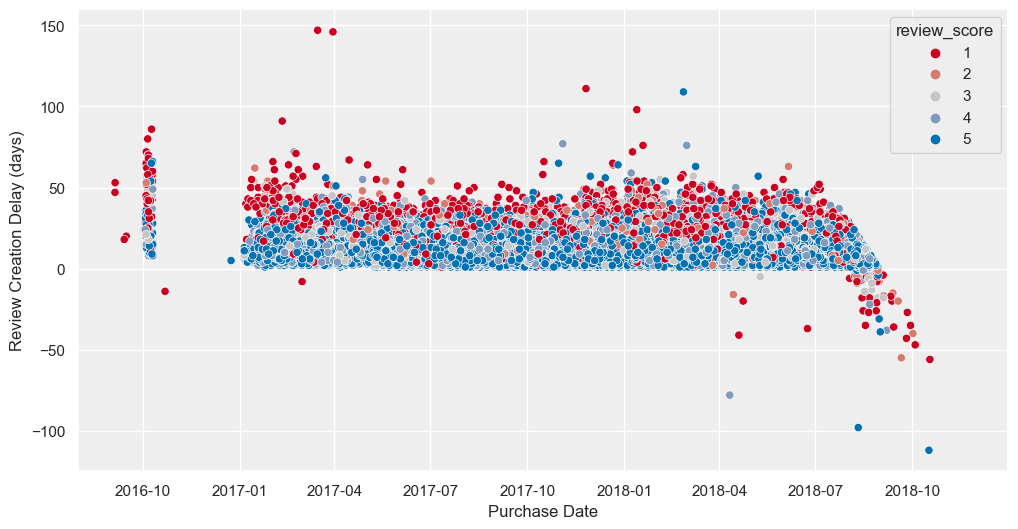

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

reviews['review_creation_delay'] = (reviews['review_creation_date'] - reviews['order_purchase_timestamp']).dt.days

x_data = reviews['order_purchase_timestamp']
y_data = reviews['review_creation_delay']
hue_data = reviews['review_score']

# Set the figure size (width, height) in inches
plt.figure(figsize=(12, 6))

ax = sns.scatterplot(
    x=x_data, 
    y=y_data, 
    hue=hue_data, 
    palette=REVIEWS_PALETTE, 
    data=reviews
)

ax.set(
    xlabel='Purchase Date', 
    ylabel='Review Creation Delay (days)'
)
ax.set_xlim(datetime(2016, 8, 1), datetime(2018, 12, 31))

plt.show()

In this analysis, we categorize reviews on a monthly basis utilizing the order_purchase_timestamp column and generate a time series plot. To avoid any peculiar patterns on the chart, only reviews created subsequent to the purchase date will be taken into account.

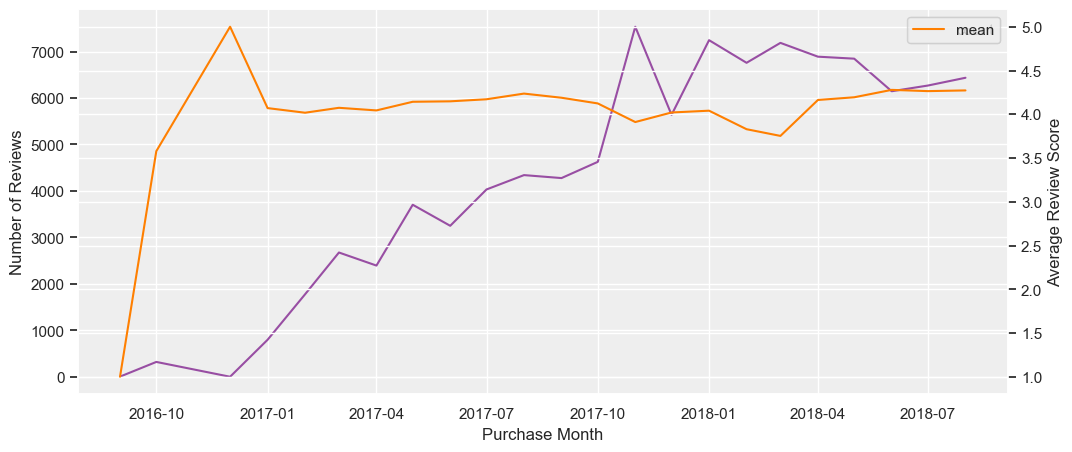

In [71]:
reviews['year_month'] = reviews['order_purchase_timestamp'].dt.to_period('M')
reviews_timeseries = reviews[reviews['review_creation_delay'] > 0].groupby('year_month')['review_score'].agg(['count', 'mean'])

x_data = reviews_timeseries.index.to_timestamp()
y_count_data = reviews_timeseries['count']
y_mean_data = reviews_timeseries['mean']

# Set the figure size (width, height) in inches
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(
    x=x_data, 
    y=y_count_data, 
    color='#984ea3', 
    label='count',
    ax=ax
)
ax.set(xlabel='Purchase Month', ylabel='Number of Reviews')

sns.lineplot(
    x=x_data,
    y=y_mean_data,
    color='#ff7f00', 
    label='mean',
    ax=ax.twinx()
).set(ylabel='Average Review Score')

resize_plot()

Reviews by checking their order status:

In [72]:
reviews.groupby('order_status')['order_status'].count()

order_status
approved           2
canceled         609
created            3
delivered      96361
invoiced         313
processing       296
shipped         1043
unavailable      597
Name: order_status, dtype: int64

By plotting the review score distribution of orders that do not have a 'delivered' status, it can see that most of them have a 1 star rating.

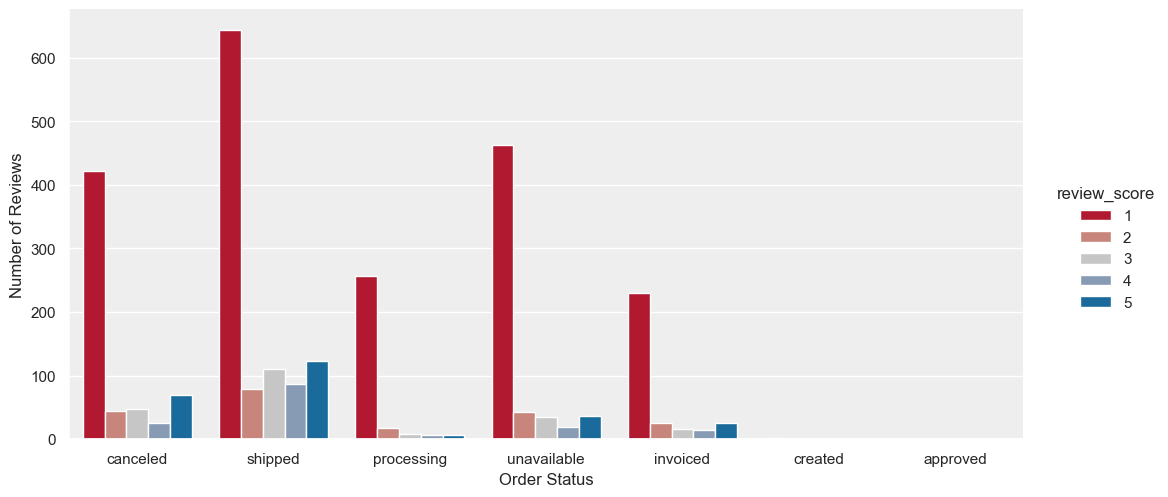

In [73]:
ax = sns.catplot(
    x='order_status',
    kind='count',
    hue='review_score',
    data=reviews[reviews['order_status'] != 'delivered'],
    palette=REVIEWS_PALETTE,
    height=6,         # Set the height of the plot in inches
    aspect=1.5        # Set the aspect ratio of the plot (width = height * aspect)
).set(xlabel='Order Status', ylabel='Number of Reviews');

resize_plot()

Regarding the extent of delay in customers' responses to Olist's satisfaction survey, an examination can be conducted by assessing the difference between the review_answer_timestamp and review_creation_date columns.

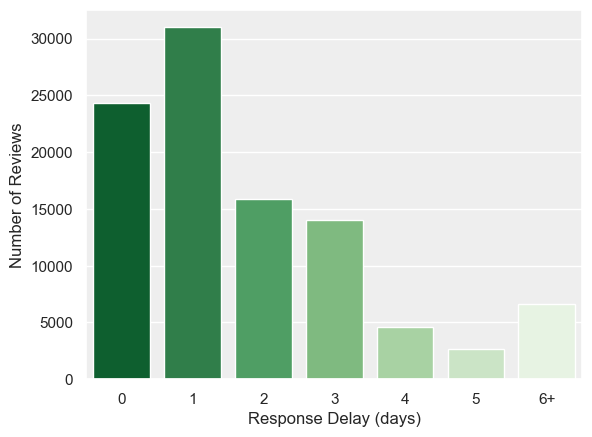

In [74]:

reviews['delay'] = (reviews['review_answer_timestamp'] - reviews['review_creation_date']).dt.days

bins = [-1, 0, 1, 2, 3, 4, 5, 99999]
labels = ['0', '1', '2', '3', '4', '5', '6+']
reviews['delay_group'] = pd.cut(reviews['delay'], bins, labels=labels)

x_data = reviews['delay_group']

ax = sns.countplot(
    x=x_data, 
    data=reviews, 
    palette=sns.color_palette('Greens_r', n_colors=7)
)

ax.set(xlabel='Response Delay (days)', ylabel='Number of Reviews')
plt.show()

Most customers wait a day before responding, unhappy customers (1 star reviews) are more likely to answer it in the same day.

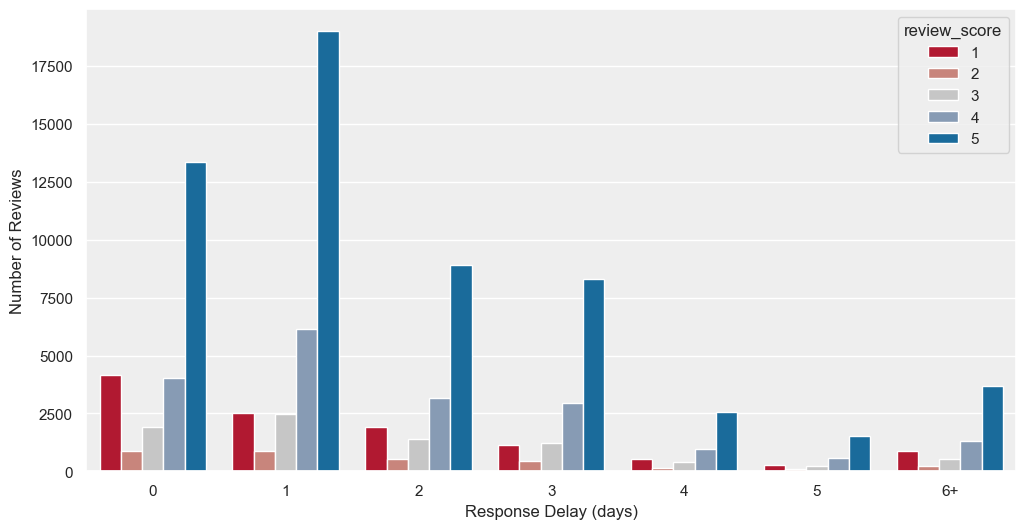

<Figure size 1200x500 with 0 Axes>

In [75]:
x_data = reviews['delay_group']

# Set the figure size (width, height) in inches
plt.figure(figsize=(12, 6))

ax = sns.countplot(
    x=x_data,
    hue='review_score',
    data=reviews,
    palette=REVIEWS_PALETTE
)

ax.set(xlabel='Response Delay (days)', ylabel='Number of Reviews')
plt.show()

resize_plot()

## Exploring Review Comments

While investigating review ratings, understanding of the aspects customers appreciate or dislike most about their experience with Olist remains limited.

To begin, let's compute the length of the review_comment_message:

In [76]:
reviews['review_length'] = reviews['review_comment_message'].str.len()
reviews[['review_score', 'review_length', 'review_comment_message']].head()

review_score  review_length                             review_comment_message
0             4            NaN                                                NaN
1             5            NaN                                                NaN
2             5            NaN                                                NaN
3             5           37.0              Recebi bem antes do prazo estipulado.
4             5          100.0  Parabéns lojas lannister adorei comprar pela I...

By defining comment rate as the number of non-NaN comments by the number of reviews.

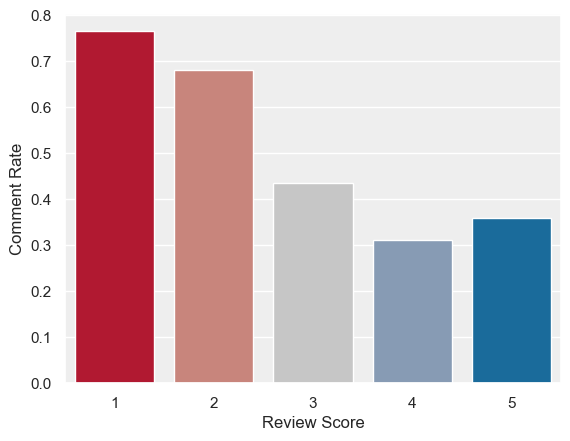

In [77]:
def comment_rate(df):
    return df['review_length'].count() / len(df)

comment_rates = reviews.groupby('review_score').apply(comment_rate)

x_data = comment_rates.index
y_data = comment_rates.values

ax = sns.barplot(
    x=x_data,
    y=y_data,
    palette=REVIEWS_PALETTE
)

ax.set(xlabel='Review Score', ylabel='Comment Rate')
plt.show()

It looks like unhappy customers are more likely to write comments

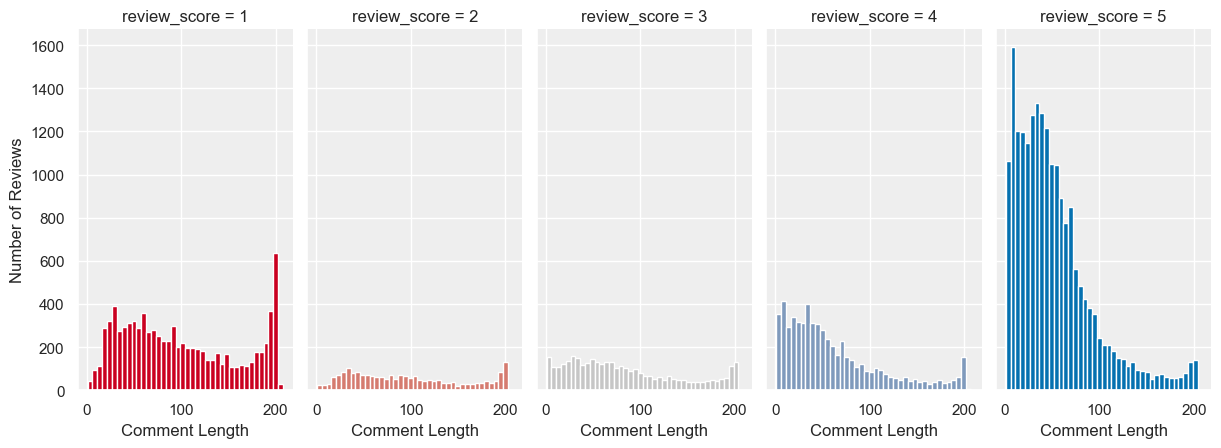

In [78]:
def plot_histogram(data, color, label, **kwargs):
    plt.hist(data['review_length'], bins=40, color=color, label=label, **kwargs)

data = reviews
palette = REVIEWS_PALETTE

g = sns.FacetGrid(data=data, col='review_score', hue='review_score', palette=palette)
g.map_dataframe(plot_histogram)

g.set_axis_labels('Comment Length', 'Number of Reviews')
g.fig.set_size_inches(12, 5)

plt.show()

What do these comments discuss? A bit of Natural Language Processing can help to uncover this information. The following process summarizes the steps involved:

1. Convert text to lowercase
2. Perform compatibility decomposition (decompose characters like ã into a~)
3. Encode to ASCII while ignoring errors (remove accents), then re-encode to UTF-8
4. Implement tokenization to split sentences into words
5. Remove stop words and non-alphabetic strings (special characters and numbers)
6. Apply lemmatization (convert a word to its base or dictionary form)*
7. Create N-grams (group adjacent lemmas within a comment)
8. Combine N-grams from all comments

**Note that lemmatization is not available for Portuguese words using the NLTK package.** While stemming was attempted, it only made the results appear less refined without further grouping the words. An alternative approach would be to translate the text to English first, but this option will be considered at a later time.

In [79]:
import nltk
import unicodedata

nltk.download('punkt')  # Download the tokenizer data
nltk.download('stopwords')  # Download the stopwords data

def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', errors='ignore').decode('utf-8')

STOP_WORDS = set(remove_accents(w) for w in nltk.corpus.stopwords.words('portuguese'))
STOP_WORDS.remove('nao')  # This word is key to understanding delivery problems later

def comments_to_words(comment):
    lowered = comment.lower()
    normalized = remove_accents(lowered)
    tokens = nltk.tokenize.word_tokenize(normalized)
    words = tuple(t for t in tokens if t not in STOP_WORDS and t.isalpha())
    return words

def words_to_ngrams(words):
    unigrams, bigrams, trigrams = [], [], []
    for comment_words in words:
        unigrams.extend(comment_words)
        bigrams.extend(' '.join(bigram) for bigram in nltk.bigrams(comment_words))
        trigrams.extend(' '.join(trigram) for trigram in nltk.trigrams(comment_words))
    
    return unigrams, bigrams, trigrams

def plot_freq(tokens, color):
    resize_plot()
    nltk.FreqDist(tokens).plot(25, cumulative=False, color=color)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Achala\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Achala\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [80]:
commented_reviews = reviews[reviews['review_comment_message'].notnull()].copy()
commented_reviews['review_comment_words'] = [comments_to_words(comment) for comment in commented_reviews['review_comment_message']]

reviews_5s = commented_reviews[commented_reviews['review_score'] == 5]
reviews_1s = commented_reviews[commented_reviews['review_score'] == 1]

unigrams_5s, bigrams_5s, trigrams_5s = words_to_ngrams(reviews_5s['review_comment_words'])
unigrams_1s, bigrams_1s, trigrams_1s = words_to_ngrams(reviews_1s['review_comment_words'])

Here are the frequency distributions for 5-star n-grams presented differently. This highlights some crucial aspects of Olist's customer experience that they appreciate:

1. Speedy delivery ('chegou antes prazo', 'entrega rapida', 'entregue antes prazo', 'super rapida')
2. Top-notch products ('produto otima qualidade', 'otimo produto', 'produto excelente', 'produto boa qualidade')
3. Secure packaging ('bem embalado', 'produto chegou bem')

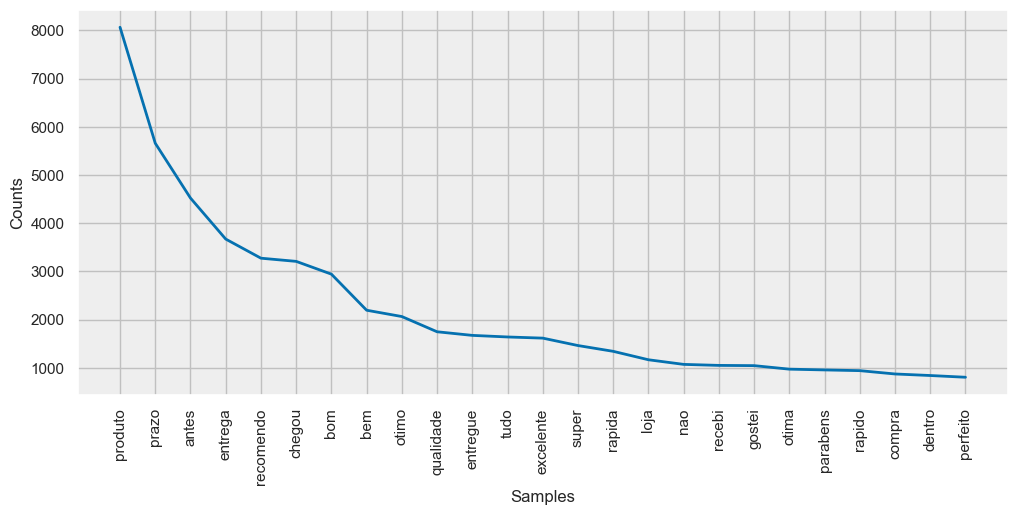

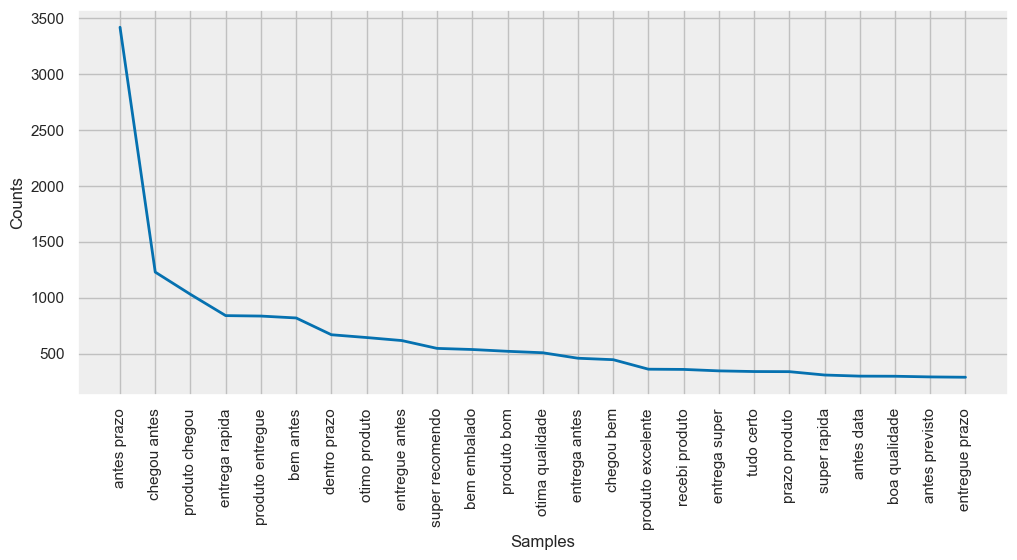

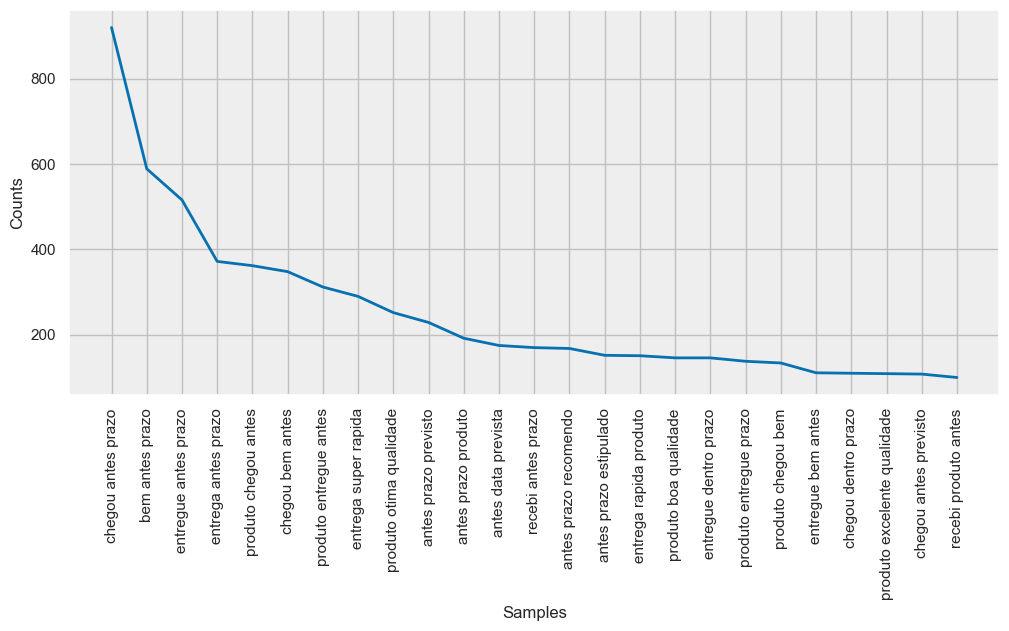

In [81]:
plot_freq(unigrams_5s, COLOR_5S)
plot_freq(bigrams_5s, COLOR_5S)
plot_freq(trigrams_5s, COLOR_5S)

Below are the frequency distributions for 1-star n-grams, which reveal some primary concerns that Olist's customers have expressed dissatisfaction about:

1. Undelivered goods ('recebi produto', 'ainda nao recebi', 'produto nao entregue', 'produto nao chegou', 'nao recebi mercadoria')
2. Issues with invoices ('nota fiscal') *
3. Seeking refunds ('quero dinheiro volta')
4. Poor quality products ('produto pessima qualidade', 'produto veio defeito')
5. Problems encountered when purchasing two items ('comprei dois produtos')
6. Negative experiences with the Lannister's shop ('lannister') *
7. Possible issues with customer service ('contato') *

The relationship between these topics and the * ratings isn't yet entirely clear, so further analysis will be conducted later.

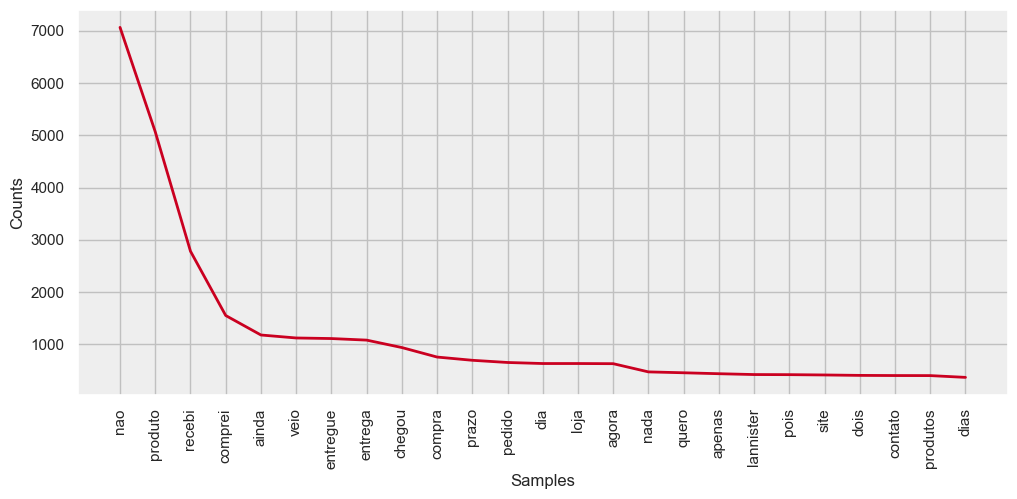

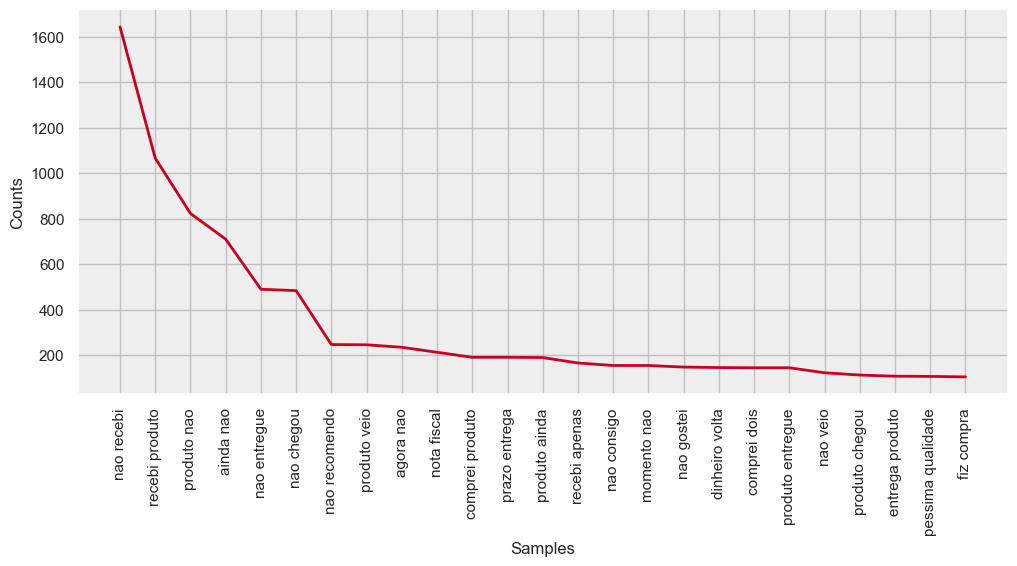

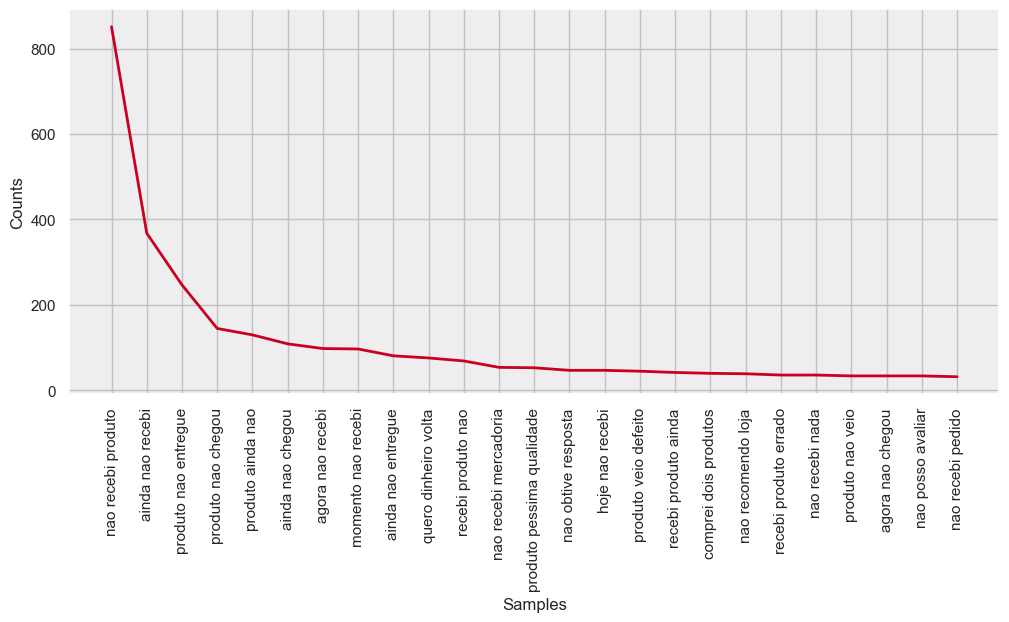

In [82]:
plot_freq(unigrams_1s, COLOR_1S)
plot_freq(bigrams_1s, COLOR_1S)
plot_freq(trigrams_1s, COLOR_1S)

Since most 1-star reviews are related to undelivered orders, this analysis focused on reviews created after the product was delivered. However, there are still comments regarding delivery issues. This analysis identified n-grams similar to those previously mentioned, as well as the following new topics:

1. Customers received incorrect items (e.g. "recebi produto errado," "produto veio errado," "produto totalmente diferente").
2. Customers received counterfeit goods (e.g. "produto nao original").

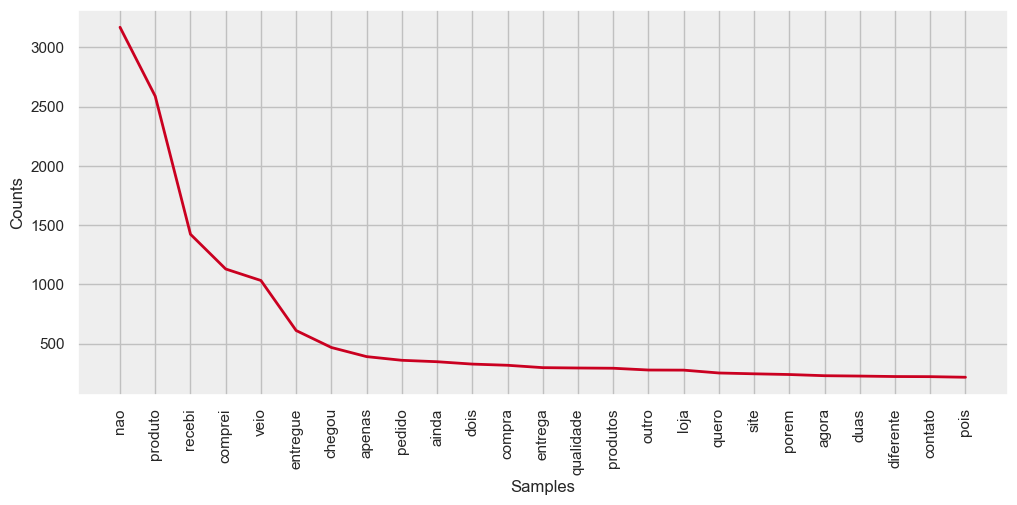

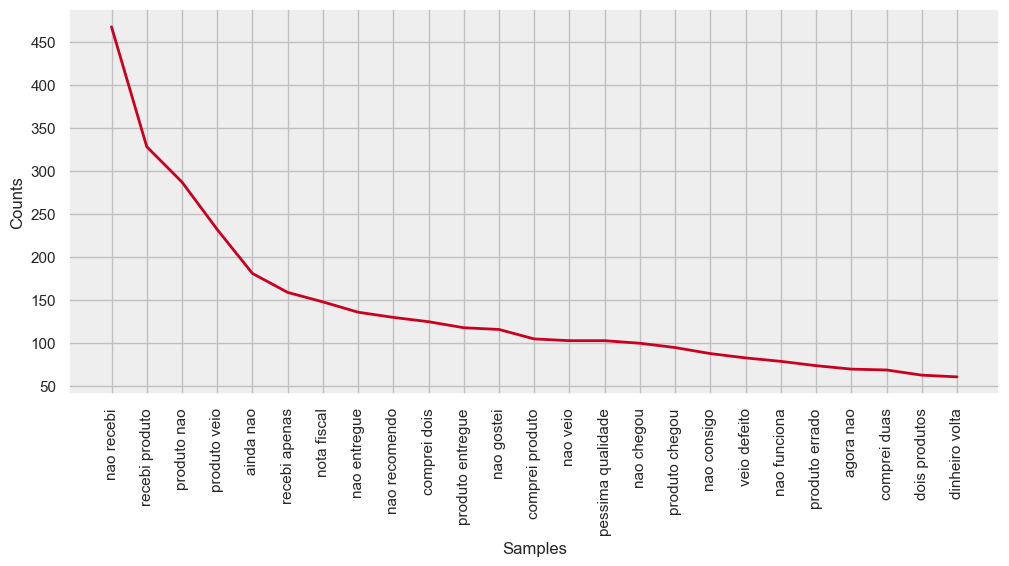

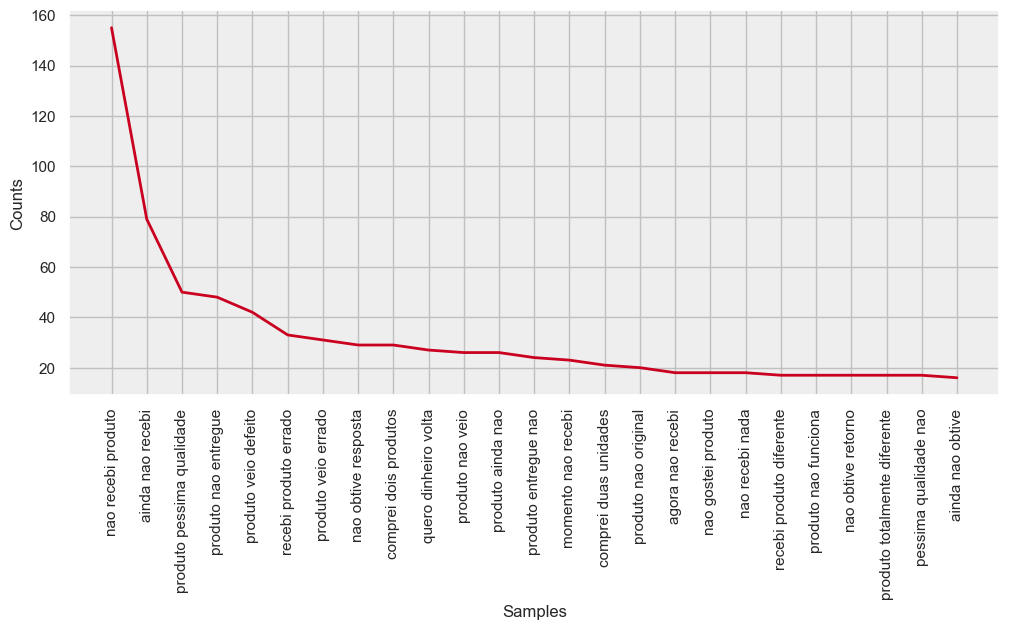

In [83]:
reviews_delivered_1s = commented_reviews[(commented_reviews['review_score'] == 1) & (commented_reviews['order_delivered_customer_date'] < commented_reviews['review_creation_date'])]
unigrams_d1s, bigrams_d1s, trigrams_d1s = words_to_ngrams(reviews_delivered_1s['review_comment_words'])

plot_freq(unigrams_d1s, COLOR_1S)
plot_freq(bigrams_d1s, COLOR_1S)
plot_freq(trigrams_d1s, COLOR_1S)

In [84]:
def search_words(df, words, n_samples=5, context_character_count=30):
    print(f'Search for "{words.upper()}"')
    words_set = set(words.split(' '))
    
    # Initial filter
    df = commented_reviews[commented_reviews['review_comment_words'].map(set) & words_set]
    
    if not len(df):
        print('> Number of reviews: 0\n')
        return

    # Filter by ordered words
    ordered_words_filter = lambda row, words: words in ' '.join(row['review_comment_words'])
    df = df[df.apply(ordered_words_filter, axis=1, args=(words,))]
    
    if len(df):
        print('> Number of reviews:', len(df))
    else:
        print('> Number of reviews: 0\n')
        return
    
    avg_rating = df['review_score'].mean()
    print(f'> Average rating: {avg_rating:.1f}★')
    
    if n_samples:
        print('> Samples:')
        first_word = words.split(' ')[0]
        for _, row in df.head(n_samples).iterrows():
            comment = row['review_comment_message'].replace('\r', '').replace('\n', '')
            score = row['review_score']
            normalized_comment = remove_accents(comment.lower())
            first_word_index = normalized_comment.index(first_word)

            i1 = first_word_index - context_character_count
            i2 = first_word_index + len(words) + context_character_count
            e1, e2 = '… ', ' …'

            if i1 < 0:
                i1 = 0
                e1 = ''

            if i2 > len(comment):
                i2 = len(comment)
                e2 = ''

            print(f'  {score}★', e1 + comment[i1:i2] + e2)
    print()

By utilizing the above function, deeper analysis can be performed. Despite a lack of proficiency in Portuguese, the following conclusions have been drawn:

1. Some individuals did not receive their invoices.
2. The reviews for the Lannister's shop were mixed among customers.
3. The seller's customer service received negative evaluations from the public and was reported as unresponsive in some cases.
4. Several customers reported receiving fake items.

In [85]:
search_words(commented_reviews, 'lannister')
search_words(commented_reviews, 'contato')
search_words(commented_reviews, 'original')

Search for "LANNISTER"
> Number of reviews: 1067
> Average rating: 3.1★
> Samples:
  5★ Parabéns lojas lannister adorei comprar pela Internet  …
  3★ … do solução por parte de Lojas lannister.
  3★ … ês após a compra. No site das lannister costumam chegar antes do praz …
  3★ … E. Quando tentei reclamar nas lannister o sistema estaav fora do ar.  …
  1★ … tes da entrega, liguei para a lannister e os atendentes não sabiam o  …

Search for "CONTATO"
> Number of reviews: 553
> Average rating: 1.6★
> Samples:
  1★ …  o produto, assim como nenhum contato por parte do .vendedor
  4★ … ra e a chegada do produto, só contato. Mas valeu.
  1★ …  quero devolver e não consigo contato! Jamais compraria novamente d …
  4★ … citei por aqui e já entrei em contato com o vendedor. Estou no agua …
  1★ … mente ruim, pois já entrei em contato e até agora nada, aí consegui …

Search for "ORIGINAL"
> Number of reviews: 344
> Average rating: 2.9★
> Samples:
  5★ … ado, com a Nota Fiscal, caixa original, gara

The analysis of customer reviews can provide important insights for improving customer experience, even with basic NLP methods. It has been observed that Olist customers are pleased with the quick shipping provided by their partners, but there is still potential for improvement. One way to achieve this is by identifying merchants who sell low-quality or fake items, those who cause undue delays or fail to provide invoices, or those who offer poor customer service.

In conclusion, the word clouds below represent 5-star and 1-star reviews.

In [86]:
def rgb_float_to_int(rgb):
    return tuple(int(255 * c) for c in rgb)

WORDCLOUD_1S_PALETTE = [rgb_float_to_int(rgb) for rgb in sns.color_palette('Reds', n_colors=9)[2:]]
WORDCLOUD_5S_PALETTE = [rgb_float_to_int(rgb) for rgb in sns.color_palette('Blues', n_colors=9)[2:]]

def get_1s_color(*args, **kwargs):
    return random.choice(WORDCLOUD_1S_PALETTE)

def get_5s_color(*args, **kwargs):
    return random.choice(WORDCLOUD_5S_PALETTE)

def plot_wordcloud(words, style):
    if style == '1s':
        color_function = get_1s_color
    elif style == '5s':
        color_function = get_5s_color
        
    wordcloud = WordCloud(background_color='white')
    wordcloud.generate(' '.join(words))
    wordcloud.recolor(color_func=color_function)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.gcf().set_size_inches(10, 5)

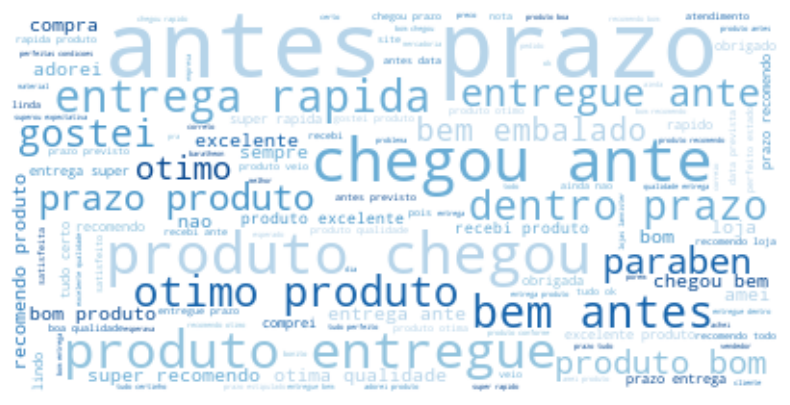

In [87]:
plot_wordcloud(unigrams_5s, '5s')

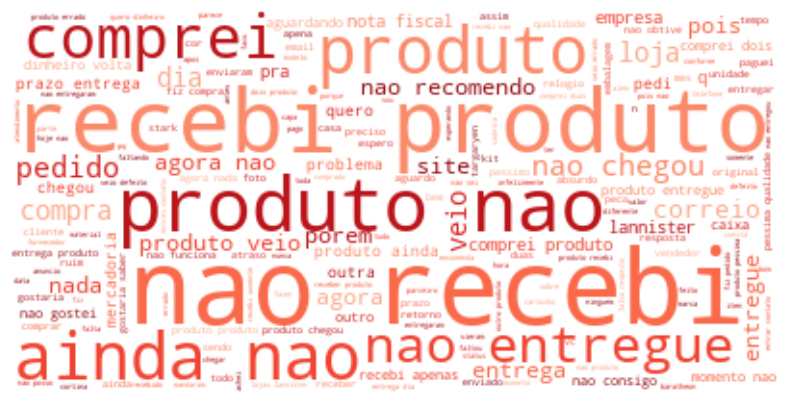

In [88]:
plot_wordcloud(unigrams_1s, '1s')